# Install libraries 


In [1]:
import sys, os, json
import mne, sklearn, wandb
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from nilearn import datasets, image, masking, plotting
from nilearn.input_data import NiftiLabelsMasker
from tqdm import tqdm

# animation part
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
# from celluloid import Camera   # it is convinient method to animate
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation


## torch libraries 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, Subset

from pytorch_model_summary import summary


/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
%load_ext autoreload
%autoreload 2
sys.path.insert(1, os.path.realpath(os.path.pardir))

from utils import get_datasets
from utils import preproc
from utils import torch_dataset
from utils import train_utils
from utils import inference
# from utils.models_arch import autoencoder_v3
from utils.models_arch import simple_models

# Set all hyperparameters
- Cuda and GPU.
- Parameters of dataset. 
- random seed( if necessary). 


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 659166.99it/s]


Sizes before (1959, 76800) (1959, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (1959, 76800) (1959, 8)
0.1


100%|██████████| 8/8 [00:20<00:00,  2.51s/it]


(8, 4399)
(8, 4399)
Name trio1 Results for Linear model with alpha: 0.1 0.9999999999995005 0.25943691649167716
PSNR:  5.0947282856330505
name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 822628.89it/s]


Sizes before (1998, 76800) (1998, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (1998, 76800) (1998, 8)
0.1


100%|██████████| 8/8 [00:21<00:00,  2.64s/it]


(8, 4399)
(8, 4399)
Name trio2 Results for Linear model with alpha: 0.1 0.9999999999977514 0.12540923847916155
PSNR:  5.061545966496059
name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 810487.30it/s]


Sizes before (1979, 76800) (1979, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (1979, 76800) (1979, 8)
0.1


100%|██████████| 8/8 [00:21<00:00,  2.70s/it]


(8, 4399)
(8, 4399)
Name trio3 Results for Linear model with alpha: 0.1 0.9999999999995215 0.5373280195213993
PSNR:  7.573199545493196
name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 818759.41it/s]


Sizes before (2076, 76800) (2076, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (2076, 76800) (2076, 8)
0.1


100%|██████████| 8/8 [00:22<00:00,  2.82s/it]


(8, 4399)
(8, 4399)
Name trio4 Results for Linear model with alpha: 0.1 0.9999999999992606 0.11400850192342016
PSNR:  8.373553227146013


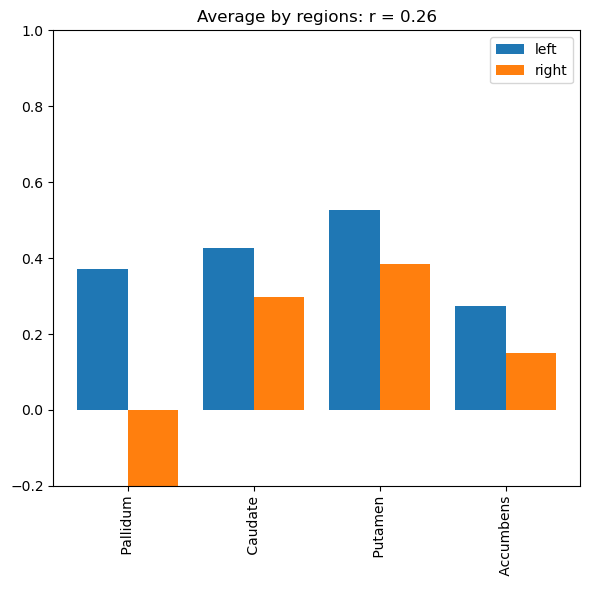

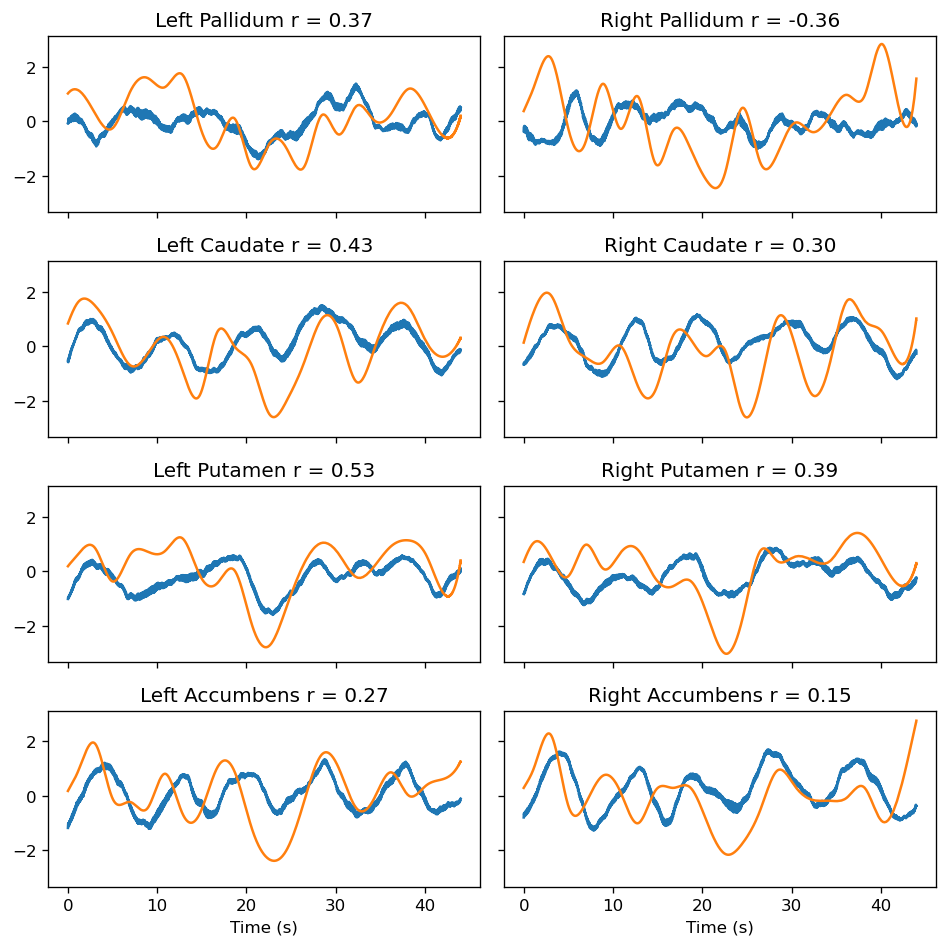

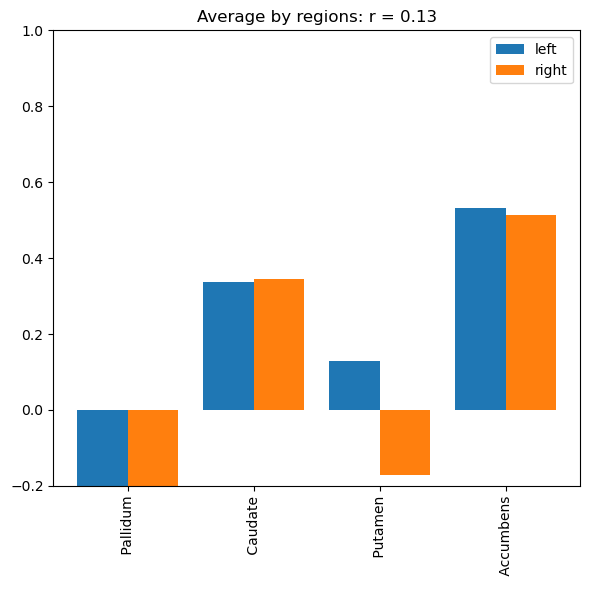

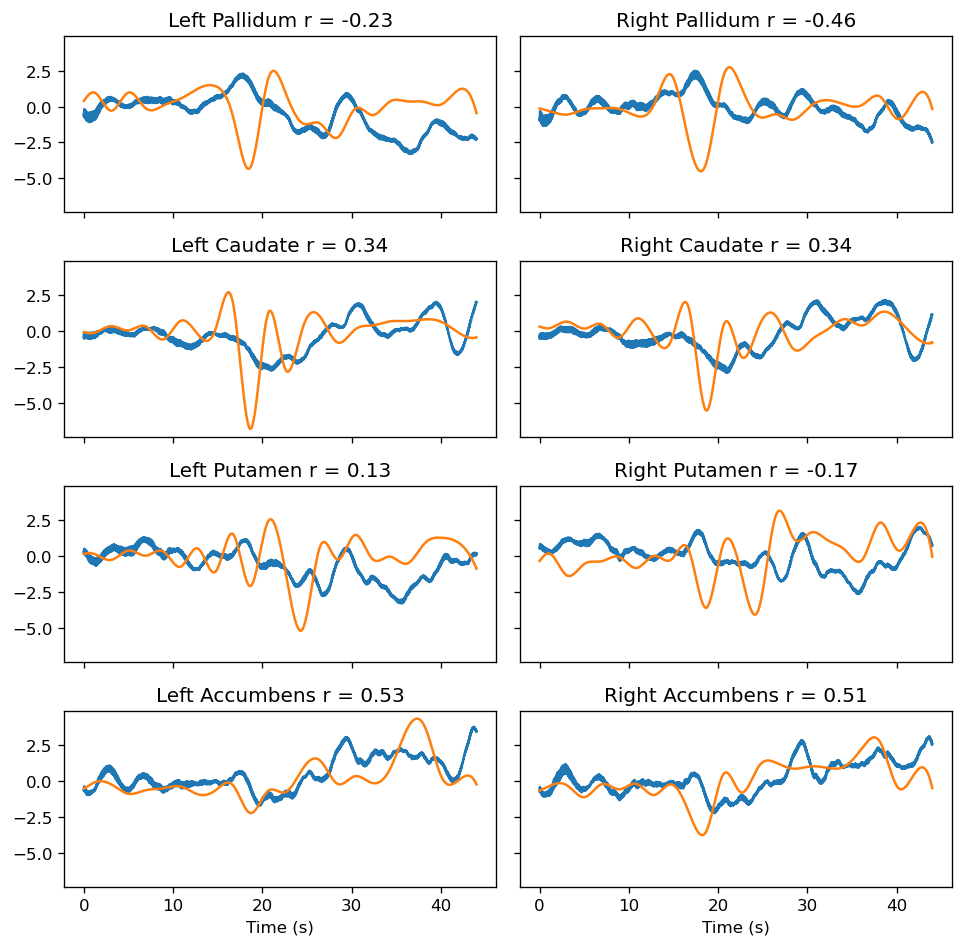

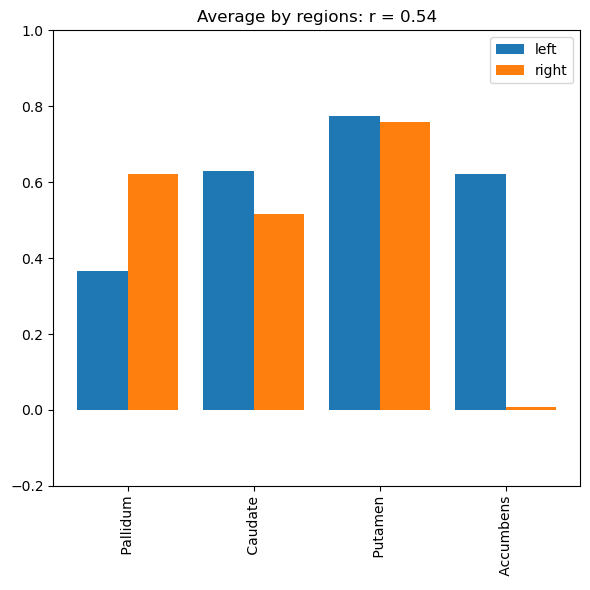

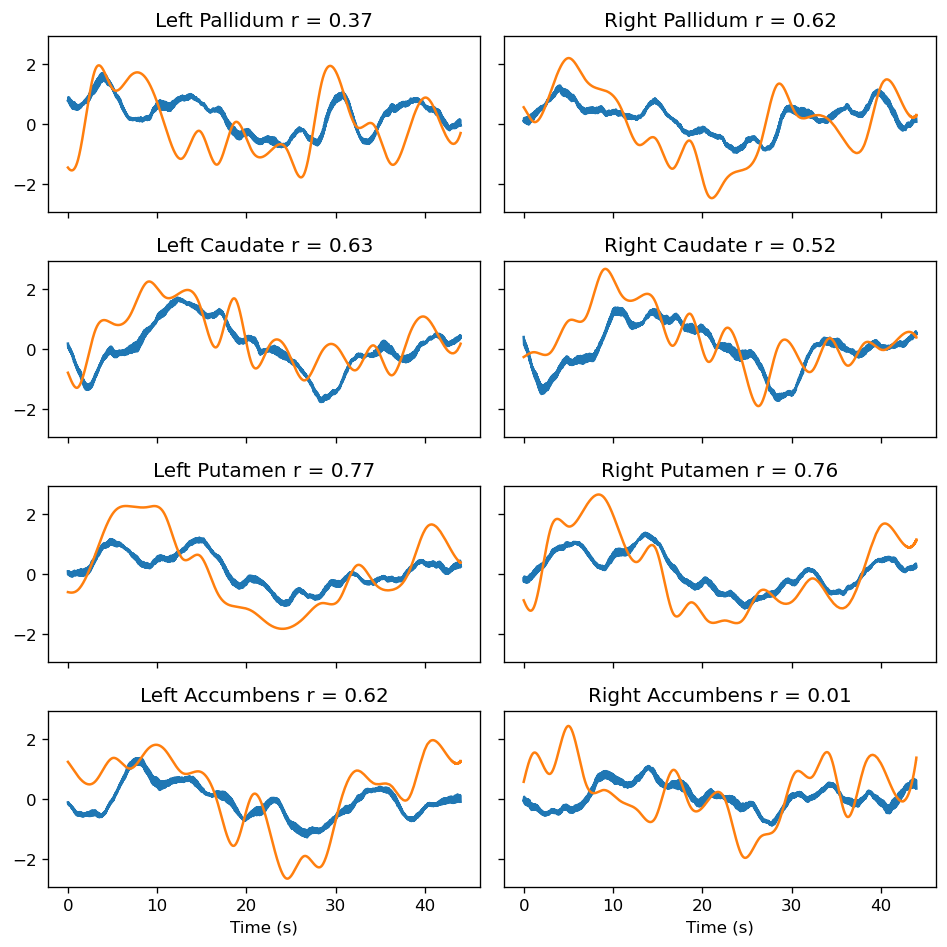

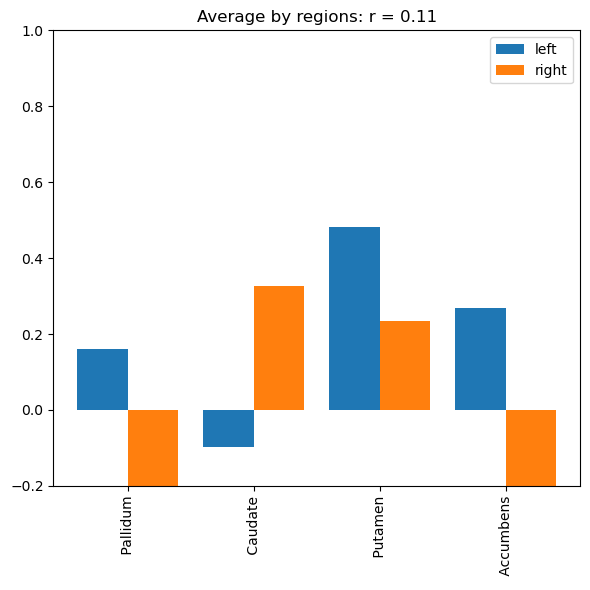

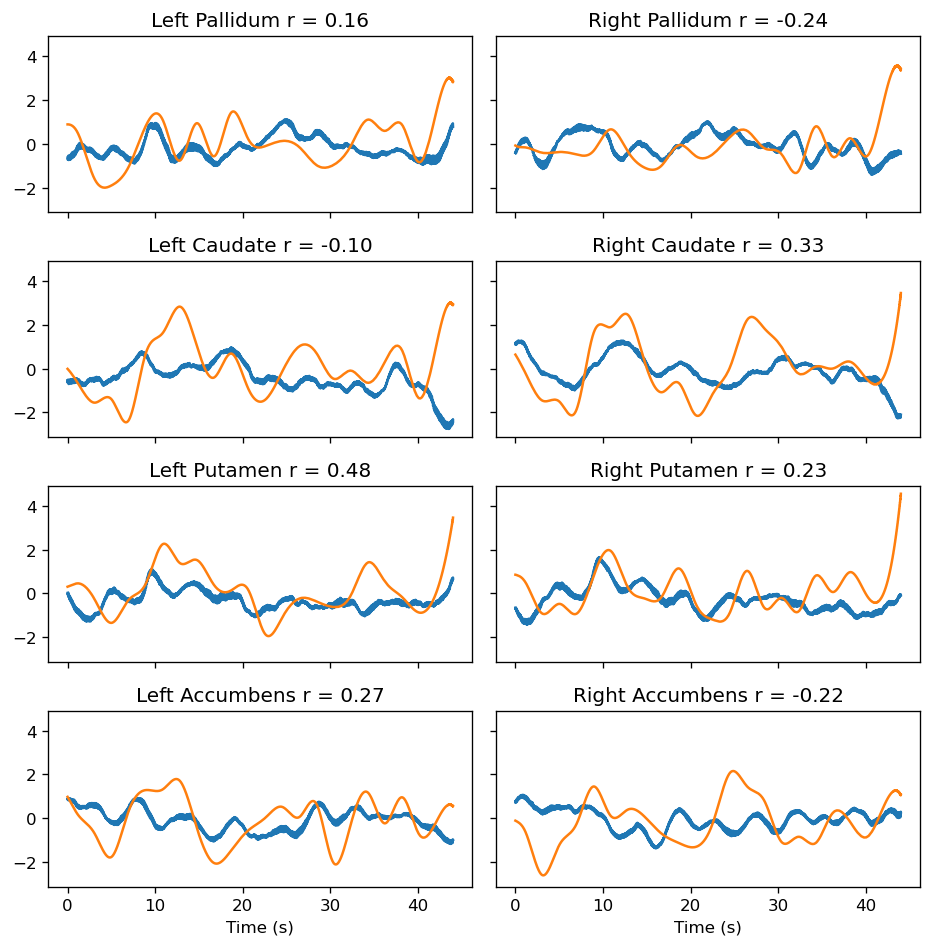

In [20]:
patients =  ['trio1', 'trio2', 'trio3', 'trio4']
for name in patients:
    config = dict(  
                    dataset_name = 'CWL', # CWL
                    new_fps=100, 
                    freqs = np.logspace(np.log10(2), np.log10(99), 16), 

                    n_channels = 30, # 30 
                    n_roi = 8,

                    bold_delay = 0,
                    to_many = False,
                    random_subsample = True,
                    sample_per_epoch = 2048, 
                    WINDOW_SIZE = 16*100,

                    optimizer='adam',
                    lr=3e-4,
                    weight_decay=0, 
                    batch_size=16, 

                    preproc_type = 'dB_log',
                    loss_function = 'mse', 
                    model_type = 'Ridge_Linear_regression'
                    )


    hp_model = dict(alpha=0.1,  # parameter of L2
                inp_stride=10, # additional downsampling for Linear Model
                step = 10 # we can not terain on all train data. 
               )

    config = {**hp_model, **config}
    params_train = {'batch_size': config['batch_size'],
                    'shuffle': True,
                    'num_workers': 0}

    params_val = {'batch_size': config['batch_size'],
                  'shuffle': False}




    #--------------------------------#
    ### Download data

    with open("../data/processed/labels_roi_6.json", 'r') as f:
        labels_roi = json.load(f)

    labels_roi = ['Left Pallidum',
                     'Left Caudate',
                     'Left Putamen',
                     'Left Accumbens',
                      
                     'Right Pallidum',
                     'Right Caudate',
                     'Right Putamen',
                     'Right Accumbens']
    with open("../data/interim/labels_roi_17.json", 'r') as f:
        labels_roi_17 = json.load(f)
    
    if config['dataset_name']=='CWL':
        
        config['patients'] = name
        dataset_path = f'../data/processed/CWL/{name}_100_hz_17_roi_2_99_freqs.npz'
        print('name', name)
    elif config['dataset_name']=='NODDI':
        dataset_path = '../data/processed/NODDI/32_100_hz_6_roi_2_99_freqs.npz'
    else:
        print('no such dataset')


    # download data
    data = np.load(dataset_path)
    
    df = pd.DataFrame(data = data['y_train'].T, columns=labels_roi_17)
    df_filter = df[labels_roi]
    y_train = df_filter.to_numpy().T
    
    df = pd.DataFrame(data = data['y_test'].T, columns=labels_roi_17)
    df_filter = df[labels_roi]
    y_test = df_filter.to_numpy().T
    
    

    train_dataset_prep = (data['x_train'], y_train)
    test_dataset_prep = (data['x_test'], y_test)


    # apply time dealy corrected
    train_dataset_prep = preproc.bold_time_delay_align(train_dataset_prep, 
                                                       config['new_fps'],
                                                       config['bold_delay'])
    test_dataset_prep = preproc.bold_time_delay_align(test_dataset_prep, 
                                                      config['new_fps'],
                                                      config['bold_delay'])


    print('Size of train dataset:', train_dataset_prep[0].shape, train_dataset_prep[1].shape)
    print('Size of test dataset:', test_dataset_prep[0].shape, test_dataset_prep[1].shape)

    # torch dataset creation 
    torch_dataset_train = torch_dataset.CreateDataset_eeg_fmri(train_dataset_prep, 
                                                                random_sample=False, 
                                                                sample_per_epoch=None, 
                                                                to_many=config['to_many'], 
                                                                window_size = config['WINDOW_SIZE'])

    torch_dataset_test = torch_dataset.CreateDataset_eeg_fmri(test_dataset_prep, 
                                                                random_sample=False, 
                                                                sample_per_epoch=None, 
                                                                to_many=config['to_many'], 
                                                                window_size = config['WINDOW_SIZE'])
    # because you do not have strid for val data. 
    # torch_dataset_test = Subset(torch_dataset_test, np.arange(len(torch_dataset_test))[::100])

    # init dataloaders for training
    train_loader = torch.utils.data.DataLoader(torch_dataset_train, **params_train)
    

    x_train, y_train = torch_dataset_train.get_full_dataset(inp_stride=config['inp_stride'], 
                                                        step=config['step'])
    x_test, y_test = torch_dataset_test.get_full_dataset(inp_stride=config['inp_stride'], 
                                                         step=1)
    x_train = x_train.reshape(len(x_train), -1)
    x_test = x_test.reshape(len(x_test), -1)

    # x_train = pca.fit_transform(x_train)
    # x_test = pca.transform(x_test)

    dataset_train = (x_train , y_train)
    dataset_test = (x_test, y_test)

    print('Sizes before', x_train.shape, y_train.shape)
    print('Sizes before', x_test.shape, y_test.shape)

    print('sizes of datasets:', dataset_train[0].shape, dataset_train[1].shape) 


    def PSNR(original, compressed):
        mse = np.mean((original - compressed) ** 2)
        if(mse == 0):  # MSE is zero means no noise is present in the signal .
                      # Therefore PSNR have no importance.
            return 100
        # max_pixel = np.max([np.max(original), np.max(compressed)])
        max_pixel = np.max(original)
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
        return psnr

    # config['alpha'] = 0.01

    # init model
    ridge_model_func = simple_models.get_Ridge_init_func(config['alpha'])

    # fit model
    roi_models, corr_train, corr_test, y_hats = simple_models.train_simple_model(ridge_model_func, 
                                                                   dataset_train,
                                                                   dataset_test)

    # # visaulization
    inference.corr_results_plot(labels_roi, corr_test)
    inference.make_visualization(y_prediction=y_hats,
                                 y_test=dataset_test[1].T, 
                                 labels=labels_roi)

    print(f'Name {name} Results for Linear model with alpha:', config['alpha'], 
          np.mean(corr_train), np.mean(corr_test))



    def mape(y, y_hat):
        return np.mean(np.abs((y - y_hat)/y)*100)
    y_hats.shape, dataset_test[1].shape

    print('PSNR: ', np.mean([PSNR(y, y_hat) for y, y_hat in zip(dataset_test[1].T, y_hats)]))

In [79]:
df_results = pd.DataFrame(columns = ['patient', 'window', 'alpha', 'stride', 'corr'])

In [ ]:
corr_dif_window_size = []

# for alpha in [0.001,
# alpha = 0.1
# stride = 20
for alpha in [ 0.01, 0.1, 1, 10, 100]:
    for stride in [5, 10, 20, 50, 100]:
        for window in [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30]:
            patients =  ['trio1', 'trio2', 'trio3', 'trio4']
            for name in patients:
                config = dict(  
                                dataset_name = 'CWL', # CWL
                                new_fps=100, 
                                freqs = np.logspace(np.log10(2), np.log10(99), 16), 

                                n_channels = 30, # 30 
                                n_roi = 8,

                                bold_delay = 0,
                                to_many = False,
                                random_subsample = True,
                                sample_per_epoch = 2048, 
                                WINDOW_SIZE = window*100,

                                optimizer='adam',
                                lr=3e-4,
                                weight_decay=0, 
                                batch_size=16, 

                                preproc_type = 'dB_log',
                                loss_function = 'mse', 
                                model_type = 'Ridge_Linear_regression'
                                )


                hp_model = dict(alpha=alpha,  # parameter of L2
                            inp_stride=stride, # additional downsampling for Linear Model
                            step = 10 # we can not terain on all train data. 
                           )

                config = {**hp_model, **config}
                params_train = {'batch_size': config['batch_size'],
                                'shuffle': True,
                                'num_workers': 0}

                params_val = {'batch_size': config['batch_size'],
                              'shuffle': False}




                #--------------------------------#
                ### Download data

                with open("../data/processed/labels_roi_6.json", 'r') as f:
                    labels_roi = json.load(f)

                labels_roi = ['Left Pallidum',
                                 'Left Caudate',
                                 'Left Putamen',
                                 'Left Accumbens',

                                 'Right Pallidum',
                                 'Right Caudate',
                                 'Right Putamen',
                                 'Right Accumbens']
                with open("../data/interim/labels_roi_17.json", 'r') as f:
                    labels_roi_17 = json.load(f)

                if config['dataset_name']=='CWL':

                    config['patients'] = name
                    dataset_path = f'../data/processed/CWL/{name}_100_hz_17_roi_2_99_freqs.npz'
                    print('name', name)
                elif config['dataset_name']=='NODDI':
                    dataset_path = '../data/processed/NODDI/32_100_hz_6_roi_2_99_freqs.npz'
                else:
                    print('no such dataset')


                # download data
                data = np.load(dataset_path)

                df = pd.DataFrame(data = data['y_train'].T, columns=labels_roi_17)
                df_filter = df[labels_roi]
                y_train = df_filter.to_numpy().T

                df = pd.DataFrame(data = data['y_test'].T, columns=labels_roi_17)
                df_filter = df[labels_roi]
                y_test = df_filter.to_numpy().T



                train_dataset_prep = (data['x_train'], y_train)
                test_dataset_prep = (data['x_test'], y_test)


                # apply time dealy corrected
                train_dataset_prep = preproc.bold_time_delay_align(train_dataset_prep, 
                                                                   config['new_fps'],
                                                                   config['bold_delay'])
                test_dataset_prep = preproc.bold_time_delay_align(test_dataset_prep, 
                                                                  config['new_fps'],
                                                                  config['bold_delay'])


                print('Size of train dataset:', train_dataset_prep[0].shape, train_dataset_prep[1].shape)
                print('Size of test dataset:', test_dataset_prep[0].shape, test_dataset_prep[1].shape)

                # torch dataset creation 
                torch_dataset_train = torch_dataset.CreateDataset_eeg_fmri(train_dataset_prep, 
                                                                            random_sample=False, 
                                                                            sample_per_epoch=None, 
                                                                            to_many=config['to_many'], 
                                                                            window_size = config['WINDOW_SIZE'])

                torch_dataset_test = torch_dataset.CreateDataset_eeg_fmri(test_dataset_prep, 
                                                                            random_sample=False, 
                                                                            sample_per_epoch=None, 
                                                                            to_many=config['to_many'], 
                                                                            window_size = config['WINDOW_SIZE'])
                # because you do not have strid for val data. 
                # torch_dataset_test = Subset(torch_dataset_test, np.arange(len(torch_dataset_test))[::100])

                # init dataloaders for training
                train_loader = torch.utils.data.DataLoader(torch_dataset_train, **params_train)


                x_train, y_train = torch_dataset_train.get_full_dataset(inp_stride=config['inp_stride'], 
                                                                    step=config['step'])
                x_test, y_test = torch_dataset_test.get_full_dataset(inp_stride=config['inp_stride'], 
                                                                     step=1)
                x_train = x_train.reshape(len(x_train), -1)
                x_test = x_test.reshape(len(x_test), -1)

                # x_train = pca.fit_transform(x_train)
                # x_test = pca.transform(x_test)

                dataset_train = (x_train , y_train)
                dataset_test = (x_test, y_test)

                print('Sizes before', x_train.shape, y_train.shape)
                print('Sizes before', x_test.shape, y_test.shape)

                print('sizes of datasets:', dataset_train[0].shape, dataset_train[1].shape) 


                def PSNR(original, compressed):
                    mse = np.mean((original - compressed) ** 2)
                    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                                  # Therefore PSNR have no importance.
                        return 100
                    # max_pixel = np.max([np.max(original), np.max(compressed)])
                    max_pixel = np.max(original)
                    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
                    return psnr

                # config['alpha'] = 0.01

                # init model
                ridge_model_func = simple_models.get_Ridge_init_func(config['alpha'])

                # fit model
                roi_models, corr_train, corr_test, y_hats = simple_models.train_simple_model(ridge_model_func, 
                                                                               dataset_train,
                                                                               dataset_test)


                dict_save = {'patient':name,
                             'window': window,
                             'alpha': hp_model['alpha'],
                             'stride': hp_model['inp_stride'], 
                             'corr': np.mean(corr_test)}
                df_results = df_results.append(dict_save, ignore_index=True)

        
df_results.to_csv('Linear_models_results', index=False)

name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 840890.89it/s]


Sizes before (2099, 19200) (2099, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2099, 19200) (2099, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 835776.54it/s]


Sizes before (2138, 19200) (2138, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2138, 19200) (2138, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 660621.68it/s]


Sizes before (2119, 19200) (2119, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2119, 19200) (2119, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 632203.59it/s]


Sizes before (2216, 19200) (2216, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2216, 19200) (2216, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 499551.33it/s]


Sizes before (2079, 38400) (2079, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2079, 38400) (2079, 8)
0.01


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 828035.26it/s]


Sizes before (2118, 38400) (2118, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2118, 38400) (2118, 8)
0.01


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 819882.98it/s]


Sizes before (2099, 38400) (2099, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2099, 38400) (2099, 8)
0.01


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 813690.03it/s]


Sizes before (2196, 38400) (2196, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2196, 38400) (2196, 8)
0.01


100%|██████████| 8/8 [00:13<00:00,  1.67s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 811563.18it/s]


Sizes before (2059, 57600) (2059, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2059, 57600) (2059, 8)
0.01


100%|██████████| 8/8 [00:16<00:00,  2.10s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 643014.66it/s]


Sizes before (2098, 57600) (2098, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2098, 57600) (2098, 8)
0.01


100%|██████████| 8/8 [00:17<00:00,  2.13s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 817953.67it/s]


Sizes before (2079, 57600) (2079, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2079, 57600) (2079, 8)
0.01


100%|██████████| 8/8 [00:17<00:00,  2.13s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 829367.39it/s]


Sizes before (2176, 57600) (2176, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2176, 57600) (2176, 8)
0.01


100%|██████████| 8/8 [00:17<00:00,  2.20s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 400525.06it/s]


Sizes before (2039, 76800) (2039, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2039, 76800) (2039, 8)
0.01


100%|██████████| 8/8 [00:22<00:00,  2.85s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 828628.46it/s]


Sizes before (2078, 76800) (2078, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2078, 76800) (2078, 8)
0.01


100%|██████████| 8/8 [00:22<00:00,  2.84s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 797301.15it/s]


Sizes before (2059, 76800) (2059, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2059, 76800) (2059, 8)
0.01


100%|██████████| 8/8 [00:22<00:00,  2.81s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 652958.03it/s]


Sizes before (2156, 76800) (2156, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2156, 76800) (2156, 8)
0.01


100%|██████████| 8/8 [00:23<00:00,  2.99s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 648962.38it/s]


Sizes before (2019, 96000) (2019, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2019, 96000) (2019, 8)
0.01


100%|██████████| 8/8 [00:25<00:00,  3.17s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 826038.12it/s]


Sizes before (2058, 96000) (2058, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2058, 96000) (2058, 8)
0.01


100%|██████████| 8/8 [00:26<00:00,  3.30s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 644652.60it/s]


Sizes before (2039, 96000) (2039, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2039, 96000) (2039, 8)
0.01


100%|██████████| 8/8 [00:25<00:00,  3.22s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 800371.25it/s]


Sizes before (2136, 96000) (2136, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2136, 96000) (2136, 8)
0.01


100%|██████████| 8/8 [00:28<00:00,  3.55s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 637097.71it/s]


Sizes before (1999, 115200) (1999, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (1999, 115200) (1999, 8)
0.01


100%|██████████| 8/8 [00:30<00:00,  3.87s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 789568.31it/s]


Sizes before (2038, 115200) (2038, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (2038, 115200) (2038, 8)
0.01


100%|██████████| 8/8 [00:32<00:00,  4.04s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 820832.92it/s]


Sizes before (2019, 115200) (2019, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (2019, 115200) (2019, 8)
0.01


100%|██████████| 8/8 [00:31<00:00,  3.99s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 645950.54it/s]


Sizes before (2116, 115200) (2116, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (2116, 115200) (2116, 8)
0.01


100%|██████████| 8/8 [00:32<00:00,  4.04s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 565180.31it/s]


Sizes before (1979, 134400) (1979, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (1979, 134400) (1979, 8)
0.01


100%|██████████| 8/8 [00:33<00:00,  4.22s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 823427.14it/s]


Sizes before (2018, 134400) (2018, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (2018, 134400) (2018, 8)
0.01


100%|██████████| 8/8 [00:33<00:00,  4.21s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 824060.33it/s]


Sizes before (1999, 134400) (1999, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (1999, 134400) (1999, 8)
0.01


100%|██████████| 8/8 [00:34<00:00,  4.37s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 605240.00it/s]


Sizes before (2096, 134400) (2096, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (2096, 134400) (2096, 8)
0.01


100%|██████████| 8/8 [00:36<00:00,  4.58s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 813417.24it/s]


Sizes before (1959, 153600) (1959, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (1959, 153600) (1959, 8)
0.01


100%|██████████| 8/8 [00:40<00:00,  5.06s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 816838.29it/s]


Sizes before (1998, 153600) (1998, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (1998, 153600) (1998, 8)
0.01


100%|██████████| 8/8 [00:41<00:00,  5.13s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 803009.24it/s]


Sizes before (1979, 153600) (1979, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (1979, 153600) (1979, 8)
0.01


100%|██████████| 8/8 [00:41<00:00,  5.13s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 733452.99it/s]


Sizes before (2076, 153600) (2076, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (2076, 153600) (2076, 8)
0.01


100%|██████████| 8/8 [00:44<00:00,  5.54s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 645833.61it/s]


Sizes before (1939, 172800) (1939, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (1939, 172800) (1939, 8)
0.01


100%|██████████| 8/8 [00:41<00:00,  5.23s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 548229.81it/s]


Sizes before (1978, 172800) (1978, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (1978, 172800) (1978, 8)
0.01


100%|██████████| 8/8 [00:44<00:00,  5.52s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 638991.46it/s]


Sizes before (1959, 172800) (1959, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (1959, 172800) (1959, 8)
0.01


100%|██████████| 8/8 [00:40<00:00,  5.09s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 816461.11it/s]


Sizes before (2056, 172800) (2056, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (2056, 172800) (2056, 8)
0.01


100%|██████████| 8/8 [00:44<00:00,  5.60s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 633135.35it/s]


Sizes before (1919, 192000) (1919, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (1919, 192000) (1919, 8)
0.01


100%|██████████| 8/8 [00:48<00:00,  6.04s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 638923.58it/s]


Sizes before (1958, 192000) (1958, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (1958, 192000) (1958, 8)
0.01


100%|██████████| 8/8 [00:46<00:00,  5.87s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 817877.01it/s]


Sizes before (1939, 192000) (1939, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (1939, 192000) (1939, 8)
0.01


100%|██████████| 8/8 [00:46<00:00,  5.82s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 812370.89it/s]


Sizes before (2036, 192000) (2036, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (2036, 192000) (2036, 8)
0.01


100%|██████████| 8/8 [00:51<00:00,  6.50s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 818235.38it/s]


Sizes before (1869, 240000) (1869, 8)
Sizes before (3499, 240000) (3499, 8)
sizes of datasets: (1869, 240000) (1869, 8)
0.01


100%|██████████| 8/8 [00:53<00:00,  6.70s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 647369.64it/s]


Sizes before (1908, 240000) (1908, 8)
Sizes before (3499, 240000) (3499, 8)
sizes of datasets: (1908, 240000) (1908, 8)
0.01


100%|██████████| 8/8 [00:55<00:00,  6.90s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 805171.98it/s]


Sizes before (1889, 240000) (1889, 8)
Sizes before (3499, 240000) (3499, 8)
sizes of datasets: (1889, 240000) (1889, 8)
0.01


100%|██████████| 8/8 [00:52<00:00,  6.60s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 811718.46it/s]


Sizes before (1986, 240000) (1986, 8)
Sizes before (3499, 240000) (3499, 8)
sizes of datasets: (1986, 240000) (1986, 8)
0.01


100%|██████████| 8/8 [00:56<00:00,  7.08s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 821708.76it/s]


Sizes before (1819, 288000) (1819, 8)
Sizes before (2999, 288000) (2999, 8)
sizes of datasets: (1819, 288000) (1819, 8)
0.01


100%|██████████| 8/8 [01:00<00:00,  7.59s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 823322.27it/s]


Sizes before (1858, 288000) (1858, 8)
Sizes before (2999, 288000) (2999, 8)
sizes of datasets: (1858, 288000) (1858, 8)
0.01


100%|██████████| 8/8 [01:00<00:00,  7.50s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 797939.46it/s]


Sizes before (1839, 288000) (1839, 8)
Sizes before (2999, 288000) (2999, 8)
sizes of datasets: (1839, 288000) (1839, 8)
0.01


100%|██████████| 8/8 [01:00<00:00,  7.57s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 813051.37it/s]


Sizes before (1936, 288000) (1936, 8)
Sizes before (2999, 288000) (2999, 8)
sizes of datasets: (1936, 288000) (1936, 8)
0.01


100%|██████████| 8/8 [01:03<00:00,  7.94s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 816583.93it/s]


Sizes before (2099, 9600) (2099, 8)
Sizes before (5799, 9600) (5799, 8)
sizes of datasets: (2099, 9600) (2099, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 808602.69it/s]


Sizes before (2138, 9600) (2138, 8)
Sizes before (5799, 9600) (5799, 8)
sizes of datasets: (2138, 9600) (2138, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 645800.09it/s]


Sizes before (2119, 9600) (2119, 8)
Sizes before (5799, 9600) (5799, 8)
sizes of datasets: (2119, 9600) (2119, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 834915.86it/s]


Sizes before (2216, 9600) (2216, 8)
Sizes before (5799, 9600) (5799, 8)
sizes of datasets: (2216, 9600) (2216, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.02it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 817314.87it/s]


Sizes before (2079, 19200) (2079, 8)
Sizes before (5599, 19200) (5599, 8)
sizes of datasets: (2079, 19200) (2079, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 797443.31it/s]


Sizes before (2118, 19200) (2118, 8)
Sizes before (5599, 19200) (5599, 8)
sizes of datasets: (2118, 19200) (2118, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 819482.43it/s]


Sizes before (2099, 19200) (2099, 8)
Sizes before (5599, 19200) (5599, 8)
sizes of datasets: (2099, 19200) (2099, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 657076.33it/s]


Sizes before (2196, 19200) (2196, 8)
Sizes before (5599, 19200) (5599, 8)
sizes of datasets: (2196, 19200) (2196, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 648576.47it/s]


Sizes before (2059, 28800) (2059, 8)
Sizes before (5399, 28800) (5399, 8)
sizes of datasets: (2059, 28800) (2059, 8)
0.01


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 808953.93it/s]


Sizes before (2098, 28800) (2098, 8)
Sizes before (5399, 28800) (5399, 8)
sizes of datasets: (2098, 28800) (2098, 8)
0.01


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 650364.67it/s]


Sizes before (2079, 28800) (2079, 8)
Sizes before (5399, 28800) (5399, 8)
sizes of datasets: (2079, 28800) (2079, 8)
0.01


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 820532.19it/s]


Sizes before (2176, 28800) (2176, 8)
Sizes before (5399, 28800) (5399, 8)
sizes of datasets: (2176, 28800) (2176, 8)
0.01


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 748222.16it/s]


Sizes before (2039, 38400) (2039, 8)
Sizes before (5199, 38400) (5199, 8)
sizes of datasets: (2039, 38400) (2039, 8)
0.01


100%|██████████| 8/8 [00:11<00:00,  1.48s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 718064.62it/s]


Sizes before (2078, 38400) (2078, 8)
Sizes before (5199, 38400) (5199, 8)
sizes of datasets: (2078, 38400) (2078, 8)
0.01


100%|██████████| 8/8 [00:12<00:00,  1.53s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 468054.40it/s]


Sizes before (2059, 38400) (2059, 8)
Sizes before (5199, 38400) (5199, 8)
sizes of datasets: (2059, 38400) (2059, 8)
0.01


100%|██████████| 8/8 [00:11<00:00,  1.50s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 568032.16it/s]


Sizes before (2156, 38400) (2156, 8)
Sizes before (5199, 38400) (5199, 8)
sizes of datasets: (2156, 38400) (2156, 8)
0.01


100%|██████████| 8/8 [00:12<00:00,  1.54s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 824998.06it/s]


Sizes before (2019, 48000) (2019, 8)
Sizes before (4999, 48000) (4999, 8)
sizes of datasets: (2019, 48000) (2019, 8)
0.01


100%|██████████| 8/8 [00:13<00:00,  1.69s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 639091.86it/s]


Sizes before (2058, 48000) (2058, 8)
Sizes before (4999, 48000) (4999, 8)
sizes of datasets: (2058, 48000) (2058, 8)
0.01


100%|██████████| 8/8 [00:13<00:00,  1.74s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 830751.05it/s]


Sizes before (2039, 48000) (2039, 8)
Sizes before (4999, 48000) (4999, 8)
sizes of datasets: (2039, 48000) (2039, 8)
0.01


100%|██████████| 8/8 [00:14<00:00,  1.81s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 657200.53it/s]


Sizes before (2136, 48000) (2136, 8)
Sizes before (4999, 48000) (4999, 8)
sizes of datasets: (2136, 48000) (2136, 8)
0.01


100%|██████████| 8/8 [00:14<00:00,  1.86s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 814093.63it/s]


Sizes before (1999, 57600) (1999, 8)
Sizes before (4799, 57600) (4799, 8)
sizes of datasets: (1999, 57600) (1999, 8)
0.01


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 830176.73it/s]


Sizes before (2038, 57600) (2038, 8)
Sizes before (4799, 57600) (4799, 8)
sizes of datasets: (2038, 57600) (2038, 8)
0.01


100%|██████████| 8/8 [00:16<00:00,  2.06s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 826223.83it/s]


Sizes before (2019, 57600) (2019, 8)
Sizes before (4799, 57600) (4799, 8)
sizes of datasets: (2019, 57600) (2019, 8)
0.01


100%|██████████| 8/8 [00:15<00:00,  1.99s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 825444.53it/s]


Sizes before (2116, 57600) (2116, 8)
Sizes before (4799, 57600) (4799, 8)
sizes of datasets: (2116, 57600) (2116, 8)
0.01


100%|██████████| 8/8 [00:16<00:00,  2.12s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 809773.06it/s]


Sizes before (1979, 67200) (1979, 8)
Sizes before (4599, 67200) (4599, 8)
sizes of datasets: (1979, 67200) (1979, 8)
0.01


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 827595.85it/s]


Sizes before (2018, 67200) (2018, 8)
Sizes before (4599, 67200) (4599, 8)
sizes of datasets: (2018, 67200) (2018, 8)
0.01


100%|██████████| 8/8 [00:17<00:00,  2.25s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 788360.47it/s]


Sizes before (1999, 67200) (1999, 8)
Sizes before (4599, 67200) (4599, 8)
sizes of datasets: (1999, 67200) (1999, 8)
0.01


100%|██████████| 8/8 [00:17<00:00,  2.13s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 817563.96it/s]


Sizes before (2096, 67200) (2096, 8)
Sizes before (4599, 67200) (4599, 8)
sizes of datasets: (2096, 67200) (2096, 8)
0.01


100%|██████████| 8/8 [00:19<00:00,  2.40s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 800570.28it/s]


Sizes before (1959, 76800) (1959, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (1959, 76800) (1959, 8)
0.01


100%|██████████| 8/8 [00:20<00:00,  2.57s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 820762.60it/s]


Sizes before (1998, 76800) (1998, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (1998, 76800) (1998, 8)
0.01


100%|██████████| 8/8 [00:21<00:00,  2.65s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 812414.39it/s]


Sizes before (1979, 76800) (1979, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (1979, 76800) (1979, 8)
0.01


100%|██████████| 8/8 [00:21<00:00,  2.66s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 825351.97it/s]


Sizes before (2076, 76800) (2076, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (2076, 76800) (2076, 8)
0.01


100%|██████████| 8/8 [00:23<00:00,  2.90s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 809369.60it/s]


Sizes before (1939, 86400) (1939, 8)
Sizes before (4199, 86400) (4199, 8)
sizes of datasets: (1939, 86400) (1939, 8)
0.01


100%|██████████| 8/8 [00:21<00:00,  2.73s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 652340.27it/s]


Sizes before (1978, 86400) (1978, 8)
Sizes before (4199, 86400) (4199, 8)
sizes of datasets: (1978, 86400) (1978, 8)
0.01


100%|██████████| 8/8 [00:22<00:00,  2.80s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 829614.32it/s]


Sizes before (1959, 86400) (1959, 8)
Sizes before (4199, 86400) (4199, 8)
sizes of datasets: (1959, 86400) (1959, 8)
0.01


100%|██████████| 8/8 [00:21<00:00,  2.71s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 541954.10it/s]


Sizes before (2056, 86400) (2056, 8)
Sizes before (4199, 86400) (4199, 8)
sizes of datasets: (2056, 86400) (2056, 8)
0.01


100%|██████████| 8/8 [00:23<00:00,  2.94s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 637563.54it/s]


Sizes before (1919, 96000) (1919, 8)
Sizes before (3999, 96000) (3999, 8)
sizes of datasets: (1919, 96000) (1919, 8)
0.01


100%|██████████| 8/8 [00:22<00:00,  2.86s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 823903.22it/s]


Sizes before (1958, 96000) (1958, 8)
Sizes before (3999, 96000) (3999, 8)
sizes of datasets: (1958, 96000) (1958, 8)
0.01


100%|██████████| 8/8 [00:23<00:00,  2.98s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 824267.61it/s]


Sizes before (1939, 96000) (1939, 8)
Sizes before (3999, 96000) (3999, 8)
sizes of datasets: (1939, 96000) (1939, 8)
0.01


100%|██████████| 8/8 [00:23<00:00,  2.92s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 637587.78it/s]


Sizes before (2036, 96000) (2036, 8)
Sizes before (3999, 96000) (3999, 8)
sizes of datasets: (2036, 96000) (2036, 8)
0.01


100%|██████████| 8/8 [00:25<00:00,  3.21s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 798208.95it/s]


Sizes before (1869, 120000) (1869, 8)
Sizes before (3499, 120000) (3499, 8)
sizes of datasets: (1869, 120000) (1869, 8)
0.01


100%|██████████| 8/8 [00:26<00:00,  3.29s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 608225.36it/s]


Sizes before (1908, 120000) (1908, 8)
Sizes before (3499, 120000) (3499, 8)
sizes of datasets: (1908, 120000) (1908, 8)
0.01


100%|██████████| 8/8 [00:27<00:00,  3.42s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 645518.79it/s]


Sizes before (1889, 120000) (1889, 8)
Sizes before (3499, 120000) (3499, 8)
sizes of datasets: (1889, 120000) (1889, 8)
0.01


100%|██████████| 8/8 [00:26<00:00,  3.35s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 833477.38it/s]


Sizes before (1986, 120000) (1986, 8)
Sizes before (3499, 120000) (3499, 8)
sizes of datasets: (1986, 120000) (1986, 8)
0.01


100%|██████████| 8/8 [00:29<00:00,  3.71s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 824942.14it/s]


Sizes before (1819, 144000) (1819, 8)
Sizes before (2999, 144000) (2999, 8)
sizes of datasets: (1819, 144000) (1819, 8)
0.01


100%|██████████| 8/8 [00:31<00:00,  3.92s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 807777.92it/s]


Sizes before (1858, 144000) (1858, 8)
Sizes before (2999, 144000) (2999, 8)
sizes of datasets: (1858, 144000) (1858, 8)
0.01


100%|██████████| 8/8 [00:31<00:00,  3.89s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 807933.57it/s]


Sizes before (1839, 144000) (1839, 8)
Sizes before (2999, 144000) (2999, 8)
sizes of datasets: (1839, 144000) (1839, 8)
0.01


100%|██████████| 8/8 [00:30<00:00,  3.79s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 814947.70it/s]


Sizes before (1936, 144000) (1936, 8)
Sizes before (2999, 144000) (2999, 8)
sizes of datasets: (1936, 144000) (1936, 8)
0.01


100%|██████████| 8/8 [00:32<00:00,  4.09s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 843193.82it/s]


Sizes before (2099, 4800) (2099, 8)
Sizes before (5799, 4800) (5799, 8)
sizes of datasets: (2099, 4800) (2099, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.21it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 778602.67it/s]


Sizes before (2138, 4800) (2138, 8)
Sizes before (5799, 4800) (5799, 8)
sizes of datasets: (2138, 4800) (2138, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.49it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 525148.31it/s]


Sizes before (2119, 4800) (2119, 8)
Sizes before (5799, 4800) (5799, 8)
sizes of datasets: (2119, 4800) (2119, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 799775.38it/s]


Sizes before (2216, 4800) (2216, 8)
Sizes before (5799, 4800) (5799, 8)
sizes of datasets: (2216, 4800) (2216, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.36it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 813690.03it/s]


Sizes before (2079, 9600) (2079, 8)
Sizes before (5599, 9600) (5599, 8)
sizes of datasets: (2079, 9600) (2079, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 541802.97it/s]


Sizes before (2118, 9600) (2118, 8)
Sizes before (5599, 9600) (5599, 8)
sizes of datasets: (2118, 9600) (2118, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 815017.29it/s]


Sizes before (2099, 9600) (2099, 8)
Sizes before (5599, 9600) (5599, 8)
sizes of datasets: (2099, 9600) (2099, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 836321.51it/s]


Sizes before (2196, 9600) (2196, 8)
Sizes before (5599, 9600) (5599, 8)
sizes of datasets: (2196, 9600) (2196, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 648465.03it/s]


Sizes before (2059, 14400) (2059, 8)
Sizes before (5399, 14400) (5399, 8)
sizes of datasets: (2059, 14400) (2059, 8)
0.01


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 798598.08it/s]


Sizes before (2098, 14400) (2098, 8)
Sizes before (5399, 14400) (5399, 8)
sizes of datasets: (2098, 14400) (2098, 8)
0.01


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 811388.70it/s]


Sizes before (2079, 14400) (2079, 8)
Sizes before (5399, 14400) (5399, 8)
sizes of datasets: (2079, 14400) (2079, 8)
0.01


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 799726.21it/s]


Sizes before (2176, 14400) (2176, 8)
Sizes before (5399, 14400) (5399, 8)
sizes of datasets: (2176, 14400) (2176, 8)
0.01


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 823434.28it/s]


Sizes before (2039, 19200) (2039, 8)
Sizes before (5199, 19200) (5199, 8)
sizes of datasets: (2039, 19200) (2039, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 661334.62it/s]


Sizes before (2078, 19200) (2078, 8)
Sizes before (5199, 19200) (5199, 8)
sizes of datasets: (2078, 19200) (2078, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 651572.79it/s]


Sizes before (2059, 19200) (2059, 8)
Sizes before (5199, 19200) (5199, 8)
sizes of datasets: (2059, 19200) (2059, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 812723.58it/s]


Sizes before (2156, 19200) (2156, 8)
Sizes before (5199, 19200) (5199, 8)
sizes of datasets: (2156, 19200) (2156, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 828060.73it/s]


Sizes before (2019, 24000) (2019, 8)
Sizes before (4999, 24000) (4999, 8)
sizes of datasets: (2019, 24000) (2019, 8)
0.01


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 814170.22it/s]


Sizes before (2058, 24000) (2058, 8)
Sizes before (4999, 24000) (4999, 8)
sizes of datasets: (2058, 24000) (2058, 8)
0.01


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 830027.54it/s]


Sizes before (2039, 24000) (2039, 8)
Sizes before (4999, 24000) (4999, 8)
sizes of datasets: (2039, 24000) (2039, 8)
0.01


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 649464.93it/s]


Sizes before (2136, 24000) (2136, 8)
Sizes before (4999, 24000) (4999, 8)
sizes of datasets: (2136, 24000) (2136, 8)
0.01


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 808112.45it/s]


Sizes before (1999, 28800) (1999, 8)
Sizes before (4799, 28800) (4799, 8)
sizes of datasets: (1999, 28800) (1999, 8)
0.01


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 816802.54it/s]


Sizes before (2038, 28800) (2038, 8)
Sizes before (4799, 28800) (4799, 8)
sizes of datasets: (2038, 28800) (2038, 8)
0.01


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 816140.17it/s]


Sizes before (2019, 28800) (2019, 8)
Sizes before (4799, 28800) (4799, 8)
sizes of datasets: (2019, 28800) (2019, 8)
0.01


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 639547.07it/s]


Sizes before (2116, 28800) (2116, 8)
Sizes before (4799, 28800) (4799, 8)
sizes of datasets: (2116, 28800) (2116, 8)
0.01


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 812262.26it/s]


Sizes before (1979, 33600) (1979, 8)
Sizes before (4599, 33600) (4599, 8)
sizes of datasets: (1979, 33600) (1979, 8)
0.01


100%|██████████| 8/8 [00:09<00:00,  1.24s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 649766.03it/s]


Sizes before (2018, 33600) (2018, 8)
Sizes before (4599, 33600) (4599, 8)
sizes of datasets: (2018, 33600) (2018, 8)
0.01


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 379216.47it/s]


Sizes before (1999, 33600) (1999, 8)
Sizes before (4599, 33600) (4599, 8)
sizes of datasets: (1999, 33600) (1999, 8)
0.01


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 652447.29it/s]


Sizes before (2096, 33600) (2096, 8)
Sizes before (4599, 33600) (4599, 8)
sizes of datasets: (2096, 33600) (2096, 8)
0.01


100%|██████████| 8/8 [00:10<00:00,  1.27s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 548003.90it/s]


Sizes before (1959, 38400) (1959, 8)
Sizes before (4399, 38400) (4399, 8)
sizes of datasets: (1959, 38400) (1959, 8)
0.01


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 827498.91it/s]


Sizes before (1998, 38400) (1998, 8)
Sizes before (4399, 38400) (4399, 8)
sizes of datasets: (1998, 38400) (1998, 8)
0.01


100%|██████████| 8/8 [00:11<00:00,  1.47s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 625491.33it/s]


Sizes before (1979, 38400) (1979, 8)
Sizes before (4399, 38400) (4399, 8)
sizes of datasets: (1979, 38400) (1979, 8)
0.01


100%|██████████| 8/8 [00:11<00:00,  1.42s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 801997.01it/s]


Sizes before (2076, 38400) (2076, 8)
Sizes before (4399, 38400) (4399, 8)
sizes of datasets: (2076, 38400) (2076, 8)
0.01


100%|██████████| 8/8 [00:12<00:00,  1.52s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 823369.92it/s]


Sizes before (1939, 43200) (1939, 8)
Sizes before (4199, 43200) (4199, 8)
sizes of datasets: (1939, 43200) (1939, 8)
0.01


100%|██████████| 8/8 [00:11<00:00,  1.43s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 821488.06it/s]


Sizes before (1978, 43200) (1978, 8)
Sizes before (4199, 43200) (4199, 8)
sizes of datasets: (1978, 43200) (1978, 8)
0.01


100%|██████████| 8/8 [00:12<00:00,  1.53s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 802985.57it/s]


Sizes before (1959, 43200) (1959, 8)
Sizes before (4199, 43200) (4199, 8)
sizes of datasets: (1959, 43200) (1959, 8)
0.01


100%|██████████| 8/8 [00:11<00:00,  1.42s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 774966.23it/s]


Sizes before (2056, 43200) (2056, 8)
Sizes before (4199, 43200) (4199, 8)
sizes of datasets: (2056, 43200) (2056, 8)
0.01


100%|██████████| 8/8 [00:11<00:00,  1.48s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 801271.76it/s]


Sizes before (1919, 48000) (1919, 8)
Sizes before (3999, 48000) (3999, 8)
sizes of datasets: (1919, 48000) (1919, 8)
0.01


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 818156.27it/s]


Sizes before (1958, 48000) (1958, 8)
Sizes before (3999, 48000) (3999, 8)
sizes of datasets: (1958, 48000) (1958, 8)
0.01


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 823134.99it/s]


Sizes before (1939, 48000) (1939, 8)
Sizes before (3999, 48000) (3999, 8)
sizes of datasets: (1939, 48000) (1939, 8)
0.01


100%|██████████| 8/8 [00:12<00:00,  1.61s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 648633.81it/s]


Sizes before (2036, 48000) (2036, 8)
Sizes before (3999, 48000) (3999, 8)
sizes of datasets: (2036, 48000) (2036, 8)
0.01


100%|██████████| 8/8 [00:13<00:00,  1.69s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 821303.36it/s]


Sizes before (1869, 60000) (1869, 8)
Sizes before (3499, 60000) (3499, 8)
sizes of datasets: (1869, 60000) (1869, 8)
0.01


100%|██████████| 8/8 [00:14<00:00,  1.81s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 827182.37it/s]


Sizes before (1908, 60000) (1908, 8)
Sizes before (3499, 60000) (3499, 8)
sizes of datasets: (1908, 60000) (1908, 8)
0.01


100%|██████████| 8/8 [00:14<00:00,  1.80s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 831776.79it/s]


Sizes before (1889, 60000) (1889, 8)
Sizes before (3499, 60000) (3499, 8)
sizes of datasets: (1889, 60000) (1889, 8)
0.01


100%|██████████| 8/8 [00:13<00:00,  1.73s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 654354.81it/s]


Sizes before (1986, 60000) (1986, 8)
Sizes before (3499, 60000) (3499, 8)
sizes of datasets: (1986, 60000) (1986, 8)
0.01


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 818607.16it/s]


Sizes before (1819, 72000) (1819, 8)
Sizes before (2999, 72000) (2999, 8)
sizes of datasets: (1819, 72000) (1819, 8)
0.01


100%|██████████| 8/8 [00:16<00:00,  2.09s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 818553.89it/s]


Sizes before (1858, 72000) (1858, 8)
Sizes before (2999, 72000) (2999, 8)
sizes of datasets: (1858, 72000) (1858, 8)
0.01


100%|██████████| 8/8 [00:17<00:00,  2.13s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 629975.34it/s]


Sizes before (1839, 72000) (1839, 8)
Sizes before (2999, 72000) (2999, 8)
sizes of datasets: (1839, 72000) (1839, 8)
0.01


100%|██████████| 8/8 [00:15<00:00,  1.99s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 824347.45it/s]


Sizes before (1936, 72000) (1936, 8)
Sizes before (2999, 72000) (2999, 8)
sizes of datasets: (1936, 72000) (1936, 8)
0.01


100%|██████████| 8/8 [00:17<00:00,  2.21s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 824332.98it/s]


Sizes before (2099, 1920) (2099, 8)
Sizes before (5799, 1920) (5799, 8)
sizes of datasets: (2099, 1920) (2099, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  6.66it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 829902.04it/s]


Sizes before (2138, 1920) (2138, 8)
Sizes before (5799, 1920) (5799, 8)
sizes of datasets: (2138, 1920) (2138, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  6.22it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 824193.31it/s]


Sizes before (2119, 1920) (2119, 8)
Sizes before (5799, 1920) (5799, 8)
sizes of datasets: (2119, 1920) (2119, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  6.53it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 646280.56it/s]


Sizes before (2216, 1920) (2216, 8)
Sizes before (5799, 1920) (5799, 8)
sizes of datasets: (2216, 1920) (2216, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  6.18it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 737768.47it/s]


Sizes before (2079, 3840) (2079, 8)
Sizes before (5599, 3840) (5599, 8)
sizes of datasets: (2079, 3840) (2079, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  4.12it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 643130.44it/s]


Sizes before (2118, 3840) (2118, 8)
Sizes before (5599, 3840) (5599, 8)
sizes of datasets: (2118, 3840) (2118, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  4.26it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 571857.69it/s]


Sizes before (2099, 3840) (2099, 8)
Sizes before (5599, 3840) (5599, 8)
sizes of datasets: (2099, 3840) (2099, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.90it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 536664.64it/s]


Sizes before (2196, 3840) (2196, 8)
Sizes before (5599, 3840) (5599, 8)
sizes of datasets: (2196, 3840) (2196, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.87it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 819700.55it/s]


Sizes before (2059, 5760) (2059, 8)
Sizes before (5399, 5760) (5399, 8)
sizes of datasets: (2059, 5760) (2059, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 828093.59it/s]


Sizes before (2098, 5760) (2098, 8)
Sizes before (5399, 5760) (5399, 8)
sizes of datasets: (2098, 5760) (2098, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 821097.48it/s]


Sizes before (2079, 5760) (2079, 8)
Sizes before (5399, 5760) (5399, 8)
sizes of datasets: (2079, 5760) (2079, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 806907.33it/s]


Sizes before (2176, 5760) (2176, 8)
Sizes before (5399, 5760) (5399, 8)
sizes of datasets: (2176, 5760) (2176, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 651533.85it/s]


Sizes before (2039, 7680) (2039, 8)
Sizes before (5199, 7680) (5199, 8)
sizes of datasets: (2039, 7680) (2039, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.65it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 793038.75it/s]


Sizes before (2078, 7680) (2078, 8)
Sizes before (5199, 7680) (5199, 8)
sizes of datasets: (2078, 7680) (2078, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 817997.84it/s]


Sizes before (2059, 7680) (2059, 8)
Sizes before (5199, 7680) (5199, 8)
sizes of datasets: (2059, 7680) (2059, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 795817.18it/s]


Sizes before (2156, 7680) (2156, 8)
Sizes before (5199, 7680) (5199, 8)
sizes of datasets: (2156, 7680) (2156, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 705709.19it/s]


Sizes before (2019, 9600) (2019, 8)
Sizes before (4999, 9600) (4999, 8)
sizes of datasets: (2019, 9600) (2019, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.52it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 819452.29it/s]


Sizes before (2058, 9600) (2058, 8)
Sizes before (4999, 9600) (4999, 8)
sizes of datasets: (2058, 9600) (2058, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 808300.91it/s]


Sizes before (2039, 9600) (2039, 8)
Sizes before (4999, 9600) (4999, 8)
sizes of datasets: (2039, 9600) (2039, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 819036.16it/s]


Sizes before (2136, 9600) (2136, 8)
Sizes before (4999, 9600) (4999, 8)
sizes of datasets: (2136, 9600) (2136, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.05it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 827957.09it/s]


Sizes before (1999, 11520) (1999, 8)
Sizes before (4799, 11520) (4799, 8)
sizes of datasets: (1999, 11520) (1999, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 813665.81it/s]


Sizes before (2038, 11520) (2038, 8)
Sizes before (4799, 11520) (4799, 8)
sizes of datasets: (2038, 11520) (2038, 8)
0.01


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 632771.61it/s]


Sizes before (2019, 11520) (2019, 8)
Sizes before (4799, 11520) (4799, 8)
sizes of datasets: (2019, 11520) (2019, 8)
0.01


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 785194.65it/s]


Sizes before (2116, 11520) (2116, 8)
Sizes before (4799, 11520) (4799, 8)
sizes of datasets: (2116, 11520) (2116, 8)
0.01


100%|██████████| 8/8 [00:04<00:00,  1.82it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 828164.35it/s]


Sizes before (1979, 13440) (1979, 8)
Sizes before (4599, 13440) (4599, 8)
sizes of datasets: (1979, 13440) (1979, 8)
0.01


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 826390.37it/s]


Sizes before (2018, 13440) (2018, 8)
Sizes before (4599, 13440) (4599, 8)
sizes of datasets: (2018, 13440) (2018, 8)
0.01


100%|██████████| 8/8 [00:04<00:00,  1.77it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 823813.97it/s]


Sizes before (1999, 13440) (1999, 8)
Sizes before (4599, 13440) (4599, 8)
sizes of datasets: (1999, 13440) (1999, 8)
0.01


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 818396.44it/s]


Sizes before (2096, 13440) (2096, 8)
Sizes before (4599, 13440) (4599, 8)
sizes of datasets: (2096, 13440) (2096, 8)
0.01


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 628859.69it/s]


Sizes before (1959, 15360) (1959, 8)
Sizes before (4399, 15360) (4399, 8)
sizes of datasets: (1959, 15360) (1959, 8)
0.01


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 808038.16it/s]


Sizes before (1998, 15360) (1998, 8)
Sizes before (4399, 15360) (4399, 8)
sizes of datasets: (1998, 15360) (1998, 8)
0.01


100%|██████████| 8/8 [00:05<00:00,  1.56it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 631809.86it/s]


Sizes before (1979, 15360) (1979, 8)
Sizes before (4399, 15360) (4399, 8)
sizes of datasets: (1979, 15360) (1979, 8)
0.01


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 644973.02it/s]


Sizes before (2076, 15360) (2076, 8)
Sizes before (4399, 15360) (4399, 8)
sizes of datasets: (2076, 15360) (2076, 8)
0.01


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 627471.94it/s]


Sizes before (1939, 17280) (1939, 8)
Sizes before (4199, 17280) (4199, 8)
sizes of datasets: (1939, 17280) (1939, 8)
0.01


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 807921.58it/s]


Sizes before (1978, 17280) (1978, 8)
Sizes before (4199, 17280) (4199, 8)
sizes of datasets: (1978, 17280) (1978, 8)
0.01


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 816764.02it/s]


Sizes before (1959, 17280) (1959, 8)
Sizes before (4199, 17280) (4199, 8)
sizes of datasets: (1959, 17280) (1959, 8)
0.01


100%|██████████| 8/8 [00:05<00:00,  1.53it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 635830.99it/s]


Sizes before (2056, 17280) (2056, 8)
Sizes before (4199, 17280) (4199, 8)
sizes of datasets: (2056, 17280) (2056, 8)
0.01


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 823660.46it/s]


Sizes before (1919, 19200) (1919, 8)
Sizes before (3999, 19200) (3999, 8)
sizes of datasets: (1919, 19200) (1919, 8)
0.01


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 814976.03it/s]


Sizes before (1958, 19200) (1958, 8)
Sizes before (3999, 19200) (3999, 8)
sizes of datasets: (1958, 19200) (1958, 8)
0.01


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 810251.76it/s]


Sizes before (1939, 19200) (1939, 8)
Sizes before (3999, 19200) (3999, 8)
sizes of datasets: (1939, 19200) (1939, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 819435.33it/s]


Sizes before (2036, 19200) (2036, 8)
Sizes before (3999, 19200) (3999, 8)
sizes of datasets: (2036, 19200) (2036, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 820247.58it/s]


Sizes before (1869, 24000) (1869, 8)
Sizes before (3499, 24000) (3499, 8)
sizes of datasets: (1869, 24000) (1869, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 824811.43it/s]


Sizes before (1908, 24000) (1908, 8)
Sizes before (3499, 24000) (3499, 8)
sizes of datasets: (1908, 24000) (1908, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 823376.89it/s]


Sizes before (1889, 24000) (1889, 8)
Sizes before (3499, 24000) (3499, 8)
sizes of datasets: (1889, 24000) (1889, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 821119.55it/s]


Sizes before (1986, 24000) (1986, 8)
Sizes before (3499, 24000) (3499, 8)
sizes of datasets: (1986, 24000) (1986, 8)
0.01


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 815106.12it/s]


Sizes before (1819, 28800) (1819, 8)
Sizes before (2999, 28800) (2999, 8)
sizes of datasets: (1819, 28800) (1819, 8)
0.01


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 657573.20it/s]


Sizes before (1858, 28800) (1858, 8)
Sizes before (2999, 28800) (2999, 8)
sizes of datasets: (1858, 28800) (1858, 8)
0.01


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 557024.08it/s]


Sizes before (1839, 28800) (1839, 8)
Sizes before (2999, 28800) (2999, 8)
sizes of datasets: (1839, 28800) (1839, 8)
0.01


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 644137.53it/s]


Sizes before (1936, 28800) (1936, 8)
Sizes before (2999, 28800) (2999, 8)
sizes of datasets: (1936, 28800) (1936, 8)
0.01


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 820633.92it/s]


Sizes before (2099, 960) (2099, 8)
Sizes before (5799, 960) (5799, 8)
sizes of datasets: (2099, 960) (2099, 8)
0.01


100%|██████████| 8/8 [00:00<00:00, 16.49it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 678364.77it/s]


Sizes before (2138, 960) (2138, 8)
Sizes before (5799, 960) (5799, 8)
sizes of datasets: (2138, 960) (2138, 8)
0.01


100%|██████████| 8/8 [00:00<00:00, 29.05it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 791808.35it/s]


Sizes before (2119, 960) (2119, 8)
Sizes before (5799, 960) (5799, 8)
sizes of datasets: (2119, 960) (2119, 8)
0.01


100%|██████████| 8/8 [00:00<00:00, 17.92it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 596672.77it/s]


Sizes before (2216, 960) (2216, 8)
Sizes before (5799, 960) (5799, 8)
sizes of datasets: (2216, 960) (2216, 8)
0.01


100%|██████████| 8/8 [00:00<00:00, 24.31it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 833058.11it/s]


Sizes before (2079, 1920) (2079, 8)
Sizes before (5599, 1920) (5599, 8)
sizes of datasets: (2079, 1920) (2079, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  6.68it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 639627.08it/s]


Sizes before (2118, 1920) (2118, 8)
Sizes before (5599, 1920) (5599, 8)
sizes of datasets: (2118, 1920) (2118, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  7.22it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 391659.57it/s]


Sizes before (2099, 1920) (2099, 8)
Sizes before (5599, 1920) (5599, 8)
sizes of datasets: (2099, 1920) (2099, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  7.60it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 631627.44it/s]


Sizes before (2196, 1920) (2196, 8)
Sizes before (5599, 1920) (5599, 8)
sizes of datasets: (2196, 1920) (2196, 8)
0.01


100%|██████████| 8/8 [00:00<00:00,  8.07it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 652031.31it/s]


Sizes before (2059, 2880) (2059, 8)
Sizes before (5399, 2880) (5399, 8)
sizes of datasets: (2059, 2880) (2059, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  5.16it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 736783.71it/s]


Sizes before (2098, 2880) (2098, 8)
Sizes before (5399, 2880) (5399, 8)
sizes of datasets: (2098, 2880) (2098, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  5.75it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 654500.05it/s]


Sizes before (2079, 2880) (2079, 8)
Sizes before (5399, 2880) (5399, 8)
sizes of datasets: (2079, 2880) (2079, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  4.32it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 815743.78it/s]


Sizes before (2176, 2880) (2176, 8)
Sizes before (5399, 2880) (5399, 8)
sizes of datasets: (2176, 2880) (2176, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  4.80it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 739895.04it/s]


Sizes before (2039, 3840) (2039, 8)
Sizes before (5199, 3840) (5199, 8)
sizes of datasets: (2039, 3840) (2039, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.90it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 795817.18it/s]


Sizes before (2078, 3840) (2078, 8)
Sizes before (5199, 3840) (5199, 8)
sizes of datasets: (2078, 3840) (2078, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  4.09it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 393357.86it/s]


Sizes before (2059, 3840) (2059, 8)
Sizes before (5199, 3840) (5199, 8)
sizes of datasets: (2059, 3840) (2059, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  4.53it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 787767.30it/s]


Sizes before (2156, 3840) (2156, 8)
Sizes before (5199, 3840) (5199, 8)
sizes of datasets: (2156, 3840) (2156, 8)
0.01


100%|██████████| 8/8 [00:01<00:00,  4.07it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 797691.68it/s]


Sizes before (2019, 4800) (2019, 8)
Sizes before (4999, 4800) (4999, 8)
sizes of datasets: (2019, 4800) (2019, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.73it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 818141.32it/s]


Sizes before (2058, 4800) (2058, 8)
Sizes before (4999, 4800) (4999, 8)
sizes of datasets: (2058, 4800) (2058, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.66it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 713392.73it/s]


Sizes before (2039, 4800) (2039, 8)
Sizes before (4999, 4800) (4999, 8)
sizes of datasets: (2039, 4800) (2039, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.46it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 746035.43it/s]


Sizes before (2136, 4800) (2136, 8)
Sizes before (4999, 4800) (4999, 8)
sizes of datasets: (2136, 4800) (2136, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.41it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 809965.99it/s]


Sizes before (1999, 5760) (1999, 8)
Sizes before (4799, 5760) (4799, 8)
sizes of datasets: (1999, 5760) (1999, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.57it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 773309.19it/s]


Sizes before (2038, 5760) (2038, 8)
Sizes before (4799, 5760) (4799, 8)
sizes of datasets: (2038, 5760) (2038, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.41it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 772537.51it/s]


Sizes before (2019, 5760) (2019, 8)
Sizes before (4799, 5760) (4799, 8)
sizes of datasets: (2019, 5760) (2019, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 714738.47it/s]


Sizes before (2116, 5760) (2116, 8)
Sizes before (4799, 5760) (4799, 8)
sizes of datasets: (2116, 5760) (2116, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 817390.74it/s]


Sizes before (1979, 6720) (1979, 8)
Sizes before (4599, 6720) (4599, 8)
sizes of datasets: (1979, 6720) (1979, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 653596.86it/s]


Sizes before (2018, 6720) (2018, 8)
Sizes before (4599, 6720) (4599, 8)
sizes of datasets: (2018, 6720) (2018, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 793843.54it/s]


Sizes before (1999, 6720) (1999, 8)
Sizes before (4599, 6720) (4599, 8)
sizes of datasets: (1999, 6720) (1999, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 540961.47it/s]


Sizes before (2096, 6720) (2096, 8)
Sizes before (4599, 6720) (4599, 8)
sizes of datasets: (2096, 6720) (2096, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.64it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 810736.59it/s]


Sizes before (1959, 7680) (1959, 8)
Sizes before (4399, 7680) (4399, 8)
sizes of datasets: (1959, 7680) (1959, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 817598.41it/s]


Sizes before (1998, 7680) (1998, 8)
Sizes before (4399, 7680) (4399, 8)
sizes of datasets: (1998, 7680) (1998, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.63it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 648532.28it/s]


Sizes before (1979, 7680) (1979, 8)
Sizes before (4399, 7680) (4399, 8)
sizes of datasets: (1979, 7680) (1979, 8)
0.01


100%|██████████| 8/8 [00:02<00:00,  2.69it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 533783.00it/s]


Sizes before (2076, 7680) (2076, 8)
Sizes before (4399, 7680) (4399, 8)
sizes of datasets: (2076, 7680) (2076, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 803791.82it/s]


Sizes before (1939, 8640) (1939, 8)
Sizes before (4199, 8640) (4199, 8)
sizes of datasets: (1939, 8640) (1939, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 782959.12it/s]


Sizes before (1978, 8640) (1978, 8)
Sizes before (4199, 8640) (4199, 8)
sizes of datasets: (1978, 8640) (1978, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 794258.25it/s]


Sizes before (1959, 8640) (1959, 8)
Sizes before (4199, 8640) (4199, 8)
sizes of datasets: (1959, 8640) (1959, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.46it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 815063.06it/s]


Sizes before (2056, 8640) (2056, 8)
Sizes before (4199, 8640) (4199, 8)
sizes of datasets: (2056, 8640) (2056, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 641440.27it/s]


Sizes before (1919, 9600) (1919, 8)
Sizes before (3999, 9600) (3999, 8)
sizes of datasets: (1919, 9600) (1919, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.49it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 642078.69it/s]


Sizes before (1958, 9600) (1958, 8)
Sizes before (3999, 9600) (3999, 8)
sizes of datasets: (1958, 9600) (1958, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.51it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 809001.19it/s]


Sizes before (1939, 9600) (1939, 8)
Sizes before (3999, 9600) (3999, 8)
sizes of datasets: (1939, 9600) (1939, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 638267.12it/s]


Sizes before (2036, 9600) (2036, 8)
Sizes before (3999, 9600) (3999, 8)
sizes of datasets: (2036, 9600) (2036, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 815960.73it/s]


Sizes before (1869, 12000) (1869, 8)
Sizes before (3499, 12000) (3499, 8)
sizes of datasets: (1869, 12000) (1869, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 648972.75it/s]


Sizes before (1908, 12000) (1908, 8)
Sizes before (3499, 12000) (3499, 8)
sizes of datasets: (1908, 12000) (1908, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 554916.24it/s]


Sizes before (1889, 12000) (1889, 8)
Sizes before (3499, 12000) (3499, 8)
sizes of datasets: (1889, 12000) (1889, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 645632.38it/s]


Sizes before (1986, 12000) (1986, 8)
Sizes before (3499, 12000) (3499, 8)
sizes of datasets: (1986, 12000) (1986, 8)
0.01


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 808245.05it/s]


Sizes before (1819, 14400) (1819, 8)
Sizes before (2999, 14400) (2999, 8)
sizes of datasets: (1819, 14400) (1819, 8)
0.01


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 823861.52it/s]


Sizes before (1858, 14400) (1858, 8)
Sizes before (2999, 14400) (2999, 8)
sizes of datasets: (1858, 14400) (1858, 8)
0.01


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 821601.42it/s]


Sizes before (1839, 14400) (1839, 8)
Sizes before (2999, 14400) (2999, 8)
sizes of datasets: (1839, 14400) (1839, 8)
0.01


100%|██████████| 8/8 [00:03<00:00,  2.05it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 805656.68it/s]


Sizes before (1936, 14400) (1936, 8)
Sizes before (2999, 14400) (2999, 8)
sizes of datasets: (1936, 14400) (1936, 8)
0.01


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 654242.38it/s]


Sizes before (2099, 19200) (2099, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2099, 19200) (2099, 8)
0.1


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 743270.04it/s]


Sizes before (2138, 19200) (2138, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2138, 19200) (2138, 8)
0.1


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 736295.00it/s]


Sizes before (2119, 19200) (2119, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2119, 19200) (2119, 8)
0.1


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 654612.15it/s]


Sizes before (2216, 19200) (2216, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2216, 19200) (2216, 8)
0.1


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 656378.45it/s]


Sizes before (2079, 38400) (2079, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2079, 38400) (2079, 8)
0.1


100%|██████████| 8/8 [00:12<00:00,  1.50s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 834805.31it/s]


Sizes before (2118, 38400) (2118, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2118, 38400) (2118, 8)
0.1


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 822467.27it/s]


Sizes before (2099, 38400) (2099, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2099, 38400) (2099, 8)
0.1


100%|██████████| 8/8 [00:12<00:00,  1.61s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 808563.15it/s]


Sizes before (2196, 38400) (2196, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2196, 38400) (2196, 8)
0.1


100%|██████████| 8/8 [00:13<00:00,  1.66s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 643051.18it/s]


Sizes before (2059, 57600) (2059, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2059, 57600) (2059, 8)
0.1


100%|██████████| 8/8 [00:16<00:00,  2.10s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 549663.75it/s]


Sizes before (2098, 57600) (2098, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2098, 57600) (2098, 8)
0.1


100%|██████████| 8/8 [00:17<00:00,  2.17s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 819611.54it/s]


Sizes before (2079, 57600) (2079, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2079, 57600) (2079, 8)
0.1


100%|██████████| 8/8 [00:17<00:00,  2.20s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 830523.26it/s]


Sizes before (2176, 57600) (2176, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2176, 57600) (2176, 8)
0.1


100%|██████████| 8/8 [00:17<00:00,  2.22s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 811302.42it/s]


Sizes before (2039, 76800) (2039, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2039, 76800) (2039, 8)
0.1


100%|██████████| 8/8 [00:22<00:00,  2.87s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 822099.40it/s]


Sizes before (2078, 76800) (2078, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2078, 76800) (2078, 8)
0.1


100%|██████████| 8/8 [00:23<00:00,  2.99s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 795497.83it/s]


Sizes before (2059, 76800) (2059, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2059, 76800) (2059, 8)
0.1


100%|██████████| 8/8 [00:23<00:00,  2.88s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 824679.92it/s]


Sizes before (2156, 76800) (2156, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2156, 76800) (2156, 8)
0.1


100%|██████████| 8/8 [00:24<00:00,  3.01s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 654186.32it/s]


Sizes before (2019, 96000) (2019, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2019, 96000) (2019, 8)
0.1


100%|██████████| 8/8 [00:25<00:00,  3.15s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 641811.07it/s]


Sizes before (2058, 96000) (2058, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2058, 96000) (2058, 8)
0.1


100%|██████████| 8/8 [00:26<00:00,  3.32s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 829206.90it/s]


Sizes before (2039, 96000) (2039, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2039, 96000) (2039, 8)
0.1


100%|██████████| 8/8 [00:26<00:00,  3.26s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 835218.52it/s]


Sizes before (2136, 96000) (2136, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2136, 96000) (2136, 8)
0.1


100%|██████████| 8/8 [00:28<00:00,  3.57s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 510965.52it/s]


Sizes before (1999, 115200) (1999, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (1999, 115200) (1999, 8)
0.1


100%|██████████| 8/8 [00:30<00:00,  3.79s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 819229.34it/s]


Sizes before (2038, 115200) (2038, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (2038, 115200) (2038, 8)
0.1


100%|██████████| 8/8 [00:31<00:00,  3.94s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 827344.52it/s]


Sizes before (2019, 115200) (2019, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (2019, 115200) (2019, 8)
0.1


100%|██████████| 8/8 [00:31<00:00,  3.97s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 550725.46it/s]


Sizes before (2116, 115200) (2116, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (2116, 115200) (2116, 8)
0.1


100%|██████████| 8/8 [00:31<00:00,  4.00s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 818049.37it/s]


Sizes before (1979, 134400) (1979, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (1979, 134400) (1979, 8)
0.1


100%|██████████| 8/8 [00:35<00:00,  4.39s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 816180.25it/s]


Sizes before (2018, 134400) (2018, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (2018, 134400) (2018, 8)
0.1


100%|██████████| 8/8 [00:33<00:00,  4.24s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 536239.41it/s]


Sizes before (1999, 134400) (1999, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (1999, 134400) (1999, 8)
0.1


100%|██████████| 8/8 [00:35<00:00,  4.38s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 637462.13it/s]


Sizes before (2096, 134400) (2096, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (2096, 134400) (2096, 8)
0.1


100%|██████████| 8/8 [00:37<00:00,  4.72s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 725037.07it/s]


Sizes before (1959, 153600) (1959, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (1959, 153600) (1959, 8)
0.1


100%|██████████| 8/8 [00:39<00:00,  4.89s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 641385.73it/s]


Sizes before (1998, 153600) (1998, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (1998, 153600) (1998, 8)
0.1


100%|██████████| 8/8 [00:40<00:00,  5.06s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 790080.22it/s]


Sizes before (1979, 153600) (1979, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (1979, 153600) (1979, 8)
0.1


100%|██████████| 8/8 [00:41<00:00,  5.17s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 826646.21it/s]


Sizes before (2076, 153600) (2076, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (2076, 153600) (2076, 8)
0.1


100%|██████████| 8/8 [00:44<00:00,  5.59s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 823215.97it/s]


Sizes before (1939, 172800) (1939, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (1939, 172800) (1939, 8)
0.1


100%|██████████| 8/8 [00:40<00:00,  5.11s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 821411.43it/s]


Sizes before (1978, 172800) (1978, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (1978, 172800) (1978, 8)
0.1


100%|██████████| 8/8 [00:43<00:00,  5.43s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 818776.50it/s]


Sizes before (1959, 172800) (1959, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (1959, 172800) (1959, 8)
0.1


100%|██████████| 8/8 [00:40<00:00,  5.12s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 813331.60it/s]


Sizes before (2056, 172800) (2056, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (2056, 172800) (2056, 8)
0.1


100%|██████████| 8/8 [00:45<00:00,  5.70s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 824510.73it/s]


Sizes before (1919, 192000) (1919, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (1919, 192000) (1919, 8)
0.1


100%|██████████| 8/8 [00:49<00:00,  6.15s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 824470.20it/s]


Sizes before (1958, 192000) (1958, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (1958, 192000) (1958, 8)
0.1


100%|██████████| 8/8 [00:48<00:00,  6.02s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 803960.20it/s]


Sizes before (1939, 192000) (1939, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (1939, 192000) (1939, 8)
0.1


100%|██████████| 8/8 [00:47<00:00,  5.99s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 827398.47it/s]


Sizes before (2036, 192000) (2036, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (2036, 192000) (2036, 8)
0.1


100%|██████████| 8/8 [00:49<00:00,  6.25s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 810329.06it/s]


Sizes before (1869, 240000) (1869, 8)
Sizes before (3499, 240000) (3499, 8)
sizes of datasets: (1869, 240000) (1869, 8)
0.1


100%|██████████| 8/8 [00:53<00:00,  6.73s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 824070.40it/s]


Sizes before (1908, 240000) (1908, 8)
Sizes before (3499, 240000) (3499, 8)
sizes of datasets: (1908, 240000) (1908, 8)
0.1


100%|██████████| 8/8 [00:54<00:00,  6.76s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 827368.91it/s]


Sizes before (1889, 240000) (1889, 8)
Sizes before (3499, 240000) (3499, 8)
sizes of datasets: (1889, 240000) (1889, 8)
0.1


100%|██████████| 8/8 [00:53<00:00,  6.69s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 834614.97it/s]


Sizes before (1986, 240000) (1986, 8)
Sizes before (3499, 240000) (3499, 8)
sizes of datasets: (1986, 240000) (1986, 8)
0.1


100%|██████████| 8/8 [00:56<00:00,  7.08s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 815476.03it/s]


Sizes before (1819, 288000) (1819, 8)
Sizes before (2999, 288000) (2999, 8)
sizes of datasets: (1819, 288000) (1819, 8)
0.1


100%|██████████| 8/8 [01:01<00:00,  7.71s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 820583.06it/s]


Sizes before (1858, 288000) (1858, 8)
Sizes before (2999, 288000) (2999, 8)
sizes of datasets: (1858, 288000) (1858, 8)
0.1


100%|██████████| 8/8 [01:01<00:00,  7.67s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 528984.30it/s]


Sizes before (1839, 288000) (1839, 8)
Sizes before (2999, 288000) (2999, 8)
sizes of datasets: (1839, 288000) (1839, 8)
0.1


100%|██████████| 8/8 [00:59<00:00,  7.43s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 534582.14it/s]


Sizes before (1936, 288000) (1936, 8)
Sizes before (2999, 288000) (2999, 8)
sizes of datasets: (1936, 288000) (1936, 8)
0.1


100%|██████████| 8/8 [01:05<00:00,  8.13s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 656290.14it/s]


Sizes before (2099, 9600) (2099, 8)
Sizes before (5799, 9600) (5799, 8)
sizes of datasets: (2099, 9600) (2099, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.08it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 832458.38it/s]


Sizes before (2138, 9600) (2138, 8)
Sizes before (5799, 9600) (5799, 8)
sizes of datasets: (2138, 9600) (2138, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 529008.85it/s]


Sizes before (2119, 9600) (2119, 8)
Sizes before (5799, 9600) (5799, 8)
sizes of datasets: (2119, 9600) (2119, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 655900.79it/s]


Sizes before (2216, 9600) (2216, 8)
Sizes before (5799, 9600) (5799, 8)
sizes of datasets: (2216, 9600) (2216, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 755960.34it/s]


Sizes before (2079, 19200) (2079, 8)
Sizes before (5599, 19200) (5599, 8)
sizes of datasets: (2079, 19200) (2079, 8)
0.1


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 752062.64it/s]


Sizes before (2118, 19200) (2118, 8)
Sizes before (5599, 19200) (5599, 8)
sizes of datasets: (2118, 19200) (2118, 8)
0.1


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 827393.44it/s]


Sizes before (2099, 19200) (2099, 8)
Sizes before (5599, 19200) (5599, 8)
sizes of datasets: (2099, 19200) (2099, 8)
0.1


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 827510.06it/s]


Sizes before (2196, 19200) (2196, 8)
Sizes before (5599, 19200) (5599, 8)
sizes of datasets: (2196, 19200) (2196, 8)
0.1


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 755061.43it/s]


Sizes before (2059, 28800) (2059, 8)
Sizes before (5399, 28800) (5399, 8)
sizes of datasets: (2059, 28800) (2059, 8)
0.1


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 817658.32it/s]


Sizes before (2098, 28800) (2098, 8)
Sizes before (5399, 28800) (5399, 8)
sizes of datasets: (2098, 28800) (2098, 8)
0.1


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 822618.69it/s]


Sizes before (2079, 28800) (2079, 8)
Sizes before (5399, 28800) (5399, 8)
sizes of datasets: (2079, 28800) (2079, 8)
0.1


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 652952.55it/s]


Sizes before (2176, 28800) (2176, 8)
Sizes before (5399, 28800) (5399, 8)
sizes of datasets: (2176, 28800) (2176, 8)
0.1


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 818519.82it/s]


Sizes before (2039, 38400) (2039, 8)
Sizes before (5199, 38400) (5199, 8)
sizes of datasets: (2039, 38400) (2039, 8)
0.1


100%|██████████| 8/8 [00:11<00:00,  1.47s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 827182.55it/s]


Sizes before (2078, 38400) (2078, 8)
Sizes before (5199, 38400) (5199, 8)
sizes of datasets: (2078, 38400) (2078, 8)
0.1


100%|██████████| 8/8 [00:12<00:00,  1.50s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 828534.01it/s]


Sizes before (2059, 38400) (2059, 8)
Sizes before (5199, 38400) (5199, 8)
sizes of datasets: (2059, 38400) (2059, 8)
0.1


100%|██████████| 8/8 [00:12<00:00,  1.54s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 815001.74it/s]


Sizes before (2156, 38400) (2156, 8)
Sizes before (5199, 38400) (5199, 8)
sizes of datasets: (2156, 38400) (2156, 8)
0.1


100%|██████████| 8/8 [00:12<00:00,  1.56s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 649404.58it/s]


Sizes before (2019, 48000) (2019, 8)
Sizes before (4999, 48000) (4999, 8)
sizes of datasets: (2019, 48000) (2019, 8)
0.1


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 651361.47it/s]


Sizes before (2058, 48000) (2058, 8)
Sizes before (4999, 48000) (4999, 8)
sizes of datasets: (2058, 48000) (2058, 8)
0.1


100%|██████████| 8/8 [00:13<00:00,  1.74s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 762198.76it/s]


Sizes before (2039, 48000) (2039, 8)
Sizes before (4999, 48000) (4999, 8)
sizes of datasets: (2039, 48000) (2039, 8)
0.1


100%|██████████| 8/8 [00:13<00:00,  1.73s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 830718.13it/s]


Sizes before (2136, 48000) (2136, 8)
Sizes before (4999, 48000) (4999, 8)
sizes of datasets: (2136, 48000) (2136, 8)
0.1


100%|██████████| 8/8 [00:15<00:00,  1.89s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 825106.17it/s]


Sizes before (1999, 57600) (1999, 8)
Sizes before (4799, 57600) (4799, 8)
sizes of datasets: (1999, 57600) (1999, 8)
0.1


100%|██████████| 8/8 [00:16<00:00,  2.02s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 825241.48it/s]


Sizes before (2038, 57600) (2038, 8)
Sizes before (4799, 57600) (4799, 8)
sizes of datasets: (2038, 57600) (2038, 8)
0.1


100%|██████████| 8/8 [00:15<00:00,  1.96s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 805525.25it/s]


Sizes before (2019, 57600) (2019, 8)
Sizes before (4799, 57600) (4799, 8)
sizes of datasets: (2019, 57600) (2019, 8)
0.1


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 664503.15it/s]


Sizes before (2116, 57600) (2116, 8)
Sizes before (4799, 57600) (4799, 8)
sizes of datasets: (2116, 57600) (2116, 8)
0.1


100%|██████████| 8/8 [00:16<00:00,  2.11s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 811169.22it/s]


Sizes before (1979, 67200) (1979, 8)
Sizes before (4599, 67200) (4599, 8)
sizes of datasets: (1979, 67200) (1979, 8)
0.1


100%|██████████| 8/8 [00:18<00:00,  2.26s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 812775.63it/s]


Sizes before (2018, 67200) (2018, 8)
Sizes before (4599, 67200) (4599, 8)
sizes of datasets: (2018, 67200) (2018, 8)
0.1


100%|██████████| 8/8 [00:18<00:00,  2.31s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 655017.29it/s]


Sizes before (1999, 67200) (1999, 8)
Sizes before (4599, 67200) (4599, 8)
sizes of datasets: (1999, 67200) (1999, 8)
0.1


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 721700.24it/s]


Sizes before (2096, 67200) (2096, 8)
Sizes before (4599, 67200) (4599, 8)
sizes of datasets: (2096, 67200) (2096, 8)
0.1


100%|██████████| 8/8 [00:19<00:00,  2.46s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 659190.54it/s]


Sizes before (1959, 76800) (1959, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (1959, 76800) (1959, 8)
0.1


100%|██████████| 8/8 [00:20<00:00,  2.58s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 826165.02it/s]


Sizes before (1998, 76800) (1998, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (1998, 76800) (1998, 8)
0.1


100%|██████████| 8/8 [00:21<00:00,  2.68s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 822372.23it/s]


Sizes before (1979, 76800) (1979, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (1979, 76800) (1979, 8)
0.1


100%|██████████| 8/8 [00:21<00:00,  2.71s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 545266.96it/s]


Sizes before (2076, 76800) (2076, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (2076, 76800) (2076, 8)
0.1


100%|██████████| 8/8 [00:23<00:00,  2.92s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 822716.05it/s]


Sizes before (1939, 86400) (1939, 8)
Sizes before (4199, 86400) (4199, 8)
sizes of datasets: (1939, 86400) (1939, 8)
0.1


100%|██████████| 8/8 [00:21<00:00,  2.69s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 825763.43it/s]


Sizes before (1978, 86400) (1978, 8)
Sizes before (4199, 86400) (4199, 8)
sizes of datasets: (1978, 86400) (1978, 8)
0.1


100%|██████████| 8/8 [00:22<00:00,  2.83s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 769481.06it/s]


Sizes before (1959, 86400) (1959, 8)
Sizes before (4199, 86400) (4199, 8)
sizes of datasets: (1959, 86400) (1959, 8)
0.1


100%|██████████| 8/8 [00:22<00:00,  2.77s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 631567.18it/s]


Sizes before (2056, 86400) (2056, 8)
Sizes before (4199, 86400) (4199, 8)
sizes of datasets: (2056, 86400) (2056, 8)
0.1


100%|██████████| 8/8 [00:23<00:00,  2.94s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 793951.61it/s]


Sizes before (1919, 96000) (1919, 8)
Sizes before (3999, 96000) (3999, 8)
sizes of datasets: (1919, 96000) (1919, 8)
0.1


100%|██████████| 8/8 [00:24<00:00,  3.01s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 790844.53it/s]


Sizes before (1958, 96000) (1958, 8)
Sizes before (3999, 96000) (3999, 8)
sizes of datasets: (1958, 96000) (1958, 8)
0.1


100%|██████████| 8/8 [00:23<00:00,  3.00s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 818555.55it/s]


Sizes before (1939, 96000) (1939, 8)
Sizes before (3999, 96000) (3999, 8)
sizes of datasets: (1939, 96000) (1939, 8)
0.1


100%|██████████| 8/8 [00:24<00:00,  3.04s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 821120.17it/s]


Sizes before (2036, 96000) (2036, 8)
Sizes before (3999, 96000) (3999, 8)
sizes of datasets: (2036, 96000) (2036, 8)
0.1


100%|██████████| 8/8 [00:25<00:00,  3.14s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 815009.15it/s]


Sizes before (1869, 120000) (1869, 8)
Sizes before (3499, 120000) (3499, 8)
sizes of datasets: (1869, 120000) (1869, 8)
0.1


100%|██████████| 8/8 [00:26<00:00,  3.32s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 819148.79it/s]


Sizes before (1908, 120000) (1908, 8)
Sizes before (3499, 120000) (3499, 8)
sizes of datasets: (1908, 120000) (1908, 8)
0.1


100%|██████████| 8/8 [00:28<00:00,  3.52s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 799165.20it/s]


Sizes before (1889, 120000) (1889, 8)
Sizes before (3499, 120000) (3499, 8)
sizes of datasets: (1889, 120000) (1889, 8)
0.1


100%|██████████| 8/8 [00:27<00:00,  3.41s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 819560.49it/s]


Sizes before (1986, 120000) (1986, 8)
Sizes before (3499, 120000) (3499, 8)
sizes of datasets: (1986, 120000) (1986, 8)
0.1


100%|██████████| 8/8 [00:29<00:00,  3.63s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 820368.99it/s]


Sizes before (1819, 144000) (1819, 8)
Sizes before (2999, 144000) (2999, 8)
sizes of datasets: (1819, 144000) (1819, 8)
0.1


100%|██████████| 8/8 [00:31<00:00,  3.88s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 826459.77it/s]


Sizes before (1858, 144000) (1858, 8)
Sizes before (2999, 144000) (2999, 8)
sizes of datasets: (1858, 144000) (1858, 8)
0.1


100%|██████████| 8/8 [00:31<00:00,  3.97s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 806948.79it/s]


Sizes before (1839, 144000) (1839, 8)
Sizes before (2999, 144000) (2999, 8)
sizes of datasets: (1839, 144000) (1839, 8)
0.1


100%|██████████| 8/8 [00:31<00:00,  3.97s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 810797.84it/s]


Sizes before (1936, 144000) (1936, 8)
Sizes before (2999, 144000) (2999, 8)
sizes of datasets: (1936, 144000) (1936, 8)
0.1


100%|██████████| 8/8 [00:33<00:00,  4.20s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 821881.76it/s]


Sizes before (2099, 4800) (2099, 8)
Sizes before (5799, 4800) (5799, 8)
sizes of datasets: (2099, 4800) (2099, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.56it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 831689.82it/s]


Sizes before (2138, 4800) (2138, 8)
Sizes before (5799, 4800) (5799, 8)
sizes of datasets: (2138, 4800) (2138, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.24it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 808145.96it/s]


Sizes before (2119, 4800) (2119, 8)
Sizes before (5799, 4800) (5799, 8)
sizes of datasets: (2119, 4800) (2119, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 724646.77it/s]


Sizes before (2216, 4800) (2216, 8)
Sizes before (5799, 4800) (5799, 8)
sizes of datasets: (2216, 4800) (2216, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.52it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 651335.68it/s]


Sizes before (2079, 9600) (2079, 8)
Sizes before (5599, 9600) (5599, 8)
sizes of datasets: (2079, 9600) (2079, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 806203.72it/s]


Sizes before (2118, 9600) (2118, 8)
Sizes before (5599, 9600) (5599, 8)
sizes of datasets: (2118, 9600) (2118, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 823649.98it/s]


Sizes before (2099, 9600) (2099, 8)
Sizes before (5599, 9600) (5599, 8)
sizes of datasets: (2099, 9600) (2099, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.07it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 789985.81it/s]


Sizes before (2196, 9600) (2196, 8)
Sizes before (5599, 9600) (5599, 8)
sizes of datasets: (2196, 9600) (2196, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 821723.18it/s]


Sizes before (2059, 14400) (2059, 8)
Sizes before (5399, 14400) (5399, 8)
sizes of datasets: (2059, 14400) (2059, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 776738.95it/s]


Sizes before (2098, 14400) (2098, 8)
Sizes before (5399, 14400) (5399, 8)
sizes of datasets: (2098, 14400) (2098, 8)
0.1


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 825437.31it/s]


Sizes before (2079, 14400) (2079, 8)
Sizes before (5399, 14400) (5399, 8)
sizes of datasets: (2079, 14400) (2079, 8)
0.1


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 652012.53it/s]


Sizes before (2176, 14400) (2176, 8)
Sizes before (5399, 14400) (5399, 8)
sizes of datasets: (2176, 14400) (2176, 8)
0.1


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 826179.68it/s]


Sizes before (2039, 19200) (2039, 8)
Sizes before (5199, 19200) (5199, 8)
sizes of datasets: (2039, 19200) (2039, 8)
0.1


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 644867.26it/s]


Sizes before (2078, 19200) (2078, 8)
Sizes before (5199, 19200) (5199, 8)
sizes of datasets: (2078, 19200) (2078, 8)
0.1


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 826555.47it/s]


Sizes before (2059, 19200) (2059, 8)
Sizes before (5199, 19200) (5199, 8)
sizes of datasets: (2059, 19200) (2059, 8)
0.1


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 554399.27it/s]


Sizes before (2156, 19200) (2156, 8)
Sizes before (5199, 19200) (5199, 8)
sizes of datasets: (2156, 19200) (2156, 8)
0.1


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 647739.44it/s]


Sizes before (2019, 24000) (2019, 8)
Sizes before (4999, 24000) (4999, 8)
sizes of datasets: (2019, 24000) (2019, 8)
0.1


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 795391.89it/s]


Sizes before (2058, 24000) (2058, 8)
Sizes before (4999, 24000) (4999, 8)
sizes of datasets: (2058, 24000) (2058, 8)
0.1


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 799943.75it/s]


Sizes before (2039, 24000) (2039, 8)
Sizes before (4999, 24000) (4999, 8)
sizes of datasets: (2039, 24000) (2039, 8)
0.1


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 637905.80it/s]


Sizes before (2136, 24000) (2136, 8)
Sizes before (4999, 24000) (4999, 8)
sizes of datasets: (2136, 24000) (2136, 8)
0.1


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 599918.48it/s]


Sizes before (1999, 28800) (1999, 8)
Sizes before (4799, 28800) (4799, 8)
sizes of datasets: (1999, 28800) (1999, 8)
0.1


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 554274.13it/s]


Sizes before (2038, 28800) (2038, 8)
Sizes before (4799, 28800) (4799, 8)
sizes of datasets: (2038, 28800) (2038, 8)
0.1


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 607761.86it/s]


Sizes before (2019, 28800) (2019, 8)
Sizes before (4799, 28800) (4799, 8)
sizes of datasets: (2019, 28800) (2019, 8)
0.1


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 775753.07it/s]


Sizes before (2116, 28800) (2116, 8)
Sizes before (4799, 28800) (4799, 8)
sizes of datasets: (2116, 28800) (2116, 8)
0.1


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 797882.37it/s]


Sizes before (1979, 33600) (1979, 8)
Sizes before (4599, 33600) (4599, 8)
sizes of datasets: (1979, 33600) (1979, 8)
0.1


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 545397.08it/s]


Sizes before (2018, 33600) (2018, 8)
Sizes before (4599, 33600) (4599, 8)
sizes of datasets: (2018, 33600) (2018, 8)
0.1


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 652226.68it/s]


Sizes before (1999, 33600) (1999, 8)
Sizes before (4599, 33600) (4599, 8)
sizes of datasets: (1999, 33600) (1999, 8)
0.1


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 657070.00it/s]


Sizes before (2096, 33600) (2096, 8)
Sizes before (4599, 33600) (4599, 8)
sizes of datasets: (2096, 33600) (2096, 8)
0.1


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 825462.75it/s]


Sizes before (1959, 38400) (1959, 8)
Sizes before (4399, 38400) (4399, 8)
sizes of datasets: (1959, 38400) (1959, 8)
0.1


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 819996.59it/s]


Sizes before (1998, 38400) (1998, 8)
Sizes before (4399, 38400) (4399, 8)
sizes of datasets: (1998, 38400) (1998, 8)
0.1


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 824172.21it/s]


Sizes before (1979, 38400) (1979, 8)
Sizes before (4399, 38400) (4399, 8)
sizes of datasets: (1979, 38400) (1979, 8)
0.1


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 657101.15it/s]


Sizes before (2076, 38400) (2076, 8)
Sizes before (4399, 38400) (4399, 8)
sizes of datasets: (2076, 38400) (2076, 8)
0.1


100%|██████████| 8/8 [00:12<00:00,  1.55s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 823062.09it/s]


Sizes before (1939, 43200) (1939, 8)
Sizes before (4199, 43200) (4199, 8)
sizes of datasets: (1939, 43200) (1939, 8)
0.1


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 814987.62it/s]


Sizes before (1978, 43200) (1978, 8)
Sizes before (4199, 43200) (4199, 8)
sizes of datasets: (1978, 43200) (1978, 8)
0.1


100%|██████████| 8/8 [00:12<00:00,  1.51s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 637672.71it/s]


Sizes before (1959, 43200) (1959, 8)
Sizes before (4199, 43200) (4199, 8)
sizes of datasets: (1959, 43200) (1959, 8)
0.1


100%|██████████| 8/8 [00:11<00:00,  1.43s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 395018.11it/s]


Sizes before (2056, 43200) (2056, 8)
Sizes before (4199, 43200) (4199, 8)
sizes of datasets: (2056, 43200) (2056, 8)
0.1


100%|██████████| 8/8 [00:12<00:00,  1.51s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 825931.74it/s]


Sizes before (1919, 48000) (1919, 8)
Sizes before (3999, 48000) (3999, 8)
sizes of datasets: (1919, 48000) (1919, 8)
0.1


100%|██████████| 8/8 [00:11<00:00,  1.49s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 826623.71it/s]


Sizes before (1958, 48000) (1958, 8)
Sizes before (3999, 48000) (3999, 8)
sizes of datasets: (1958, 48000) (1958, 8)
0.1


100%|██████████| 8/8 [00:12<00:00,  1.61s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 650798.19it/s]


Sizes before (1939, 48000) (1939, 8)
Sizes before (3999, 48000) (3999, 8)
sizes of datasets: (1939, 48000) (1939, 8)
0.1


100%|██████████| 8/8 [00:13<00:00,  1.70s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 812567.66it/s]


Sizes before (2036, 48000) (2036, 8)
Sizes before (3999, 48000) (3999, 8)
sizes of datasets: (2036, 48000) (2036, 8)
0.1


100%|██████████| 8/8 [00:13<00:00,  1.74s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 821533.23it/s]


Sizes before (1869, 60000) (1869, 8)
Sizes before (3499, 60000) (3499, 8)
sizes of datasets: (1869, 60000) (1869, 8)
0.1


100%|██████████| 8/8 [00:14<00:00,  1.76s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 809658.48it/s]


Sizes before (1908, 60000) (1908, 8)
Sizes before (3499, 60000) (3499, 8)
sizes of datasets: (1908, 60000) (1908, 8)
0.1


100%|██████████| 8/8 [00:14<00:00,  1.87s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 817688.30it/s]


Sizes before (1889, 60000) (1889, 8)
Sizes before (3499, 60000) (3499, 8)
sizes of datasets: (1889, 60000) (1889, 8)
0.1


100%|██████████| 8/8 [00:14<00:00,  1.83s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 384769.28it/s]


Sizes before (1986, 60000) (1986, 8)
Sizes before (3499, 60000) (3499, 8)
sizes of datasets: (1986, 60000) (1986, 8)
0.1


100%|██████████| 8/8 [00:15<00:00,  1.90s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 542490.09it/s]


Sizes before (1819, 72000) (1819, 8)
Sizes before (2999, 72000) (2999, 8)
sizes of datasets: (1819, 72000) (1819, 8)
0.1


100%|██████████| 8/8 [00:16<00:00,  2.03s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 792160.57it/s]


Sizes before (1858, 72000) (1858, 8)
Sizes before (2999, 72000) (2999, 8)
sizes of datasets: (1858, 72000) (1858, 8)
0.1


100%|██████████| 8/8 [00:16<00:00,  2.10s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 639032.60it/s]


Sizes before (1839, 72000) (1839, 8)
Sizes before (2999, 72000) (2999, 8)
sizes of datasets: (1839, 72000) (1839, 8)
0.1


100%|██████████| 8/8 [00:16<00:00,  2.01s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 818287.65it/s]


Sizes before (1936, 72000) (1936, 8)
Sizes before (2999, 72000) (2999, 8)
sizes of datasets: (1936, 72000) (1936, 8)
0.1


100%|██████████| 8/8 [00:17<00:00,  2.13s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 815324.78it/s]


Sizes before (2099, 1920) (2099, 8)
Sizes before (5799, 1920) (5799, 8)
sizes of datasets: (2099, 1920) (2099, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  6.98it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 652067.48it/s]


Sizes before (2138, 1920) (2138, 8)
Sizes before (5799, 1920) (5799, 8)
sizes of datasets: (2138, 1920) (2138, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  6.38it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 750679.57it/s]


Sizes before (2119, 1920) (2119, 8)
Sizes before (5799, 1920) (5799, 8)
sizes of datasets: (2119, 1920) (2119, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  6.87it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 583980.05it/s]


Sizes before (2216, 1920) (2216, 8)
Sizes before (5799, 1920) (5799, 8)
sizes of datasets: (2216, 1920) (2216, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  5.81it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 788394.54it/s]


Sizes before (2079, 3840) (2079, 8)
Sizes before (5599, 3840) (5599, 8)
sizes of datasets: (2079, 3840) (2079, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.96it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 650559.81it/s]


Sizes before (2118, 3840) (2118, 8)
Sizes before (5599, 3840) (5599, 8)
sizes of datasets: (2118, 3840) (2118, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.99it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 723895.94it/s]


Sizes before (2099, 3840) (2099, 8)
Sizes before (5599, 3840) (5599, 8)
sizes of datasets: (2099, 3840) (2099, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.80it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 829292.61it/s]


Sizes before (2196, 3840) (2196, 8)
Sizes before (5599, 3840) (5599, 8)
sizes of datasets: (2196, 3840) (2196, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  4.21it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 816861.96it/s]


Sizes before (2059, 5760) (2059, 8)
Sizes before (5399, 5760) (5399, 8)
sizes of datasets: (2059, 5760) (2059, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 805128.61it/s]


Sizes before (2098, 5760) (2098, 8)
Sizes before (5399, 5760) (5399, 8)
sizes of datasets: (2098, 5760) (2098, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.22it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 398196.69it/s]


Sizes before (2079, 5760) (2079, 8)
Sizes before (5399, 5760) (5399, 8)
sizes of datasets: (2079, 5760) (2079, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.39it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 649618.39it/s]


Sizes before (2176, 5760) (2176, 8)
Sizes before (5399, 5760) (5399, 8)
sizes of datasets: (2176, 5760) (2176, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 667243.55it/s]


Sizes before (2039, 7680) (2039, 8)
Sizes before (5199, 7680) (5199, 8)
sizes of datasets: (2039, 7680) (2039, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 806979.00it/s]


Sizes before (2078, 7680) (2078, 8)
Sizes before (5199, 7680) (5199, 8)
sizes of datasets: (2078, 7680) (2078, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 805845.77it/s]


Sizes before (2059, 7680) (2059, 8)
Sizes before (5199, 7680) (5199, 8)
sizes of datasets: (2059, 7680) (2059, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.54it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 821449.05it/s]


Sizes before (2156, 7680) (2156, 8)
Sizes before (5199, 7680) (5199, 8)
sizes of datasets: (2156, 7680) (2156, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 827701.16it/s]


Sizes before (2019, 9600) (2019, 8)
Sizes before (4999, 9600) (4999, 8)
sizes of datasets: (2019, 9600) (2019, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 817981.73it/s]


Sizes before (2058, 9600) (2058, 8)
Sizes before (4999, 9600) (4999, 8)
sizes of datasets: (2058, 9600) (2058, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 819868.84it/s]


Sizes before (2039, 9600) (2039, 8)
Sizes before (4999, 9600) (4999, 8)
sizes of datasets: (2039, 9600) (2039, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 575030.19it/s]


Sizes before (2136, 9600) (2136, 8)
Sizes before (4999, 9600) (4999, 8)
sizes of datasets: (2136, 9600) (2136, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.07it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 815974.74it/s]


Sizes before (1999, 11520) (1999, 8)
Sizes before (4799, 11520) (4799, 8)
sizes of datasets: (1999, 11520) (1999, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 805235.22it/s]


Sizes before (2038, 11520) (2038, 8)
Sizes before (4799, 11520) (4799, 8)
sizes of datasets: (2038, 11520) (2038, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 526248.13it/s]


Sizes before (2019, 11520) (2019, 8)
Sizes before (4799, 11520) (4799, 8)
sizes of datasets: (2019, 11520) (2019, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 650207.22it/s]


Sizes before (2116, 11520) (2116, 8)
Sizes before (4799, 11520) (4799, 8)
sizes of datasets: (2116, 11520) (2116, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 629741.25it/s]


Sizes before (1979, 13440) (1979, 8)
Sizes before (4599, 13440) (4599, 8)
sizes of datasets: (1979, 13440) (1979, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.78it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 645525.87it/s]


Sizes before (2018, 13440) (2018, 8)
Sizes before (4599, 13440) (4599, 8)
sizes of datasets: (2018, 13440) (2018, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 647019.89it/s]


Sizes before (1999, 13440) (1999, 8)
Sizes before (4599, 13440) (4599, 8)
sizes of datasets: (1999, 13440) (1999, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 382191.83it/s]


Sizes before (2096, 13440) (2096, 8)
Sizes before (4599, 13440) (4599, 8)
sizes of datasets: (2096, 13440) (2096, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 638765.56it/s]


Sizes before (1959, 15360) (1959, 8)
Sizes before (4399, 15360) (4399, 8)
sizes of datasets: (1959, 15360) (1959, 8)
0.1


100%|██████████| 8/8 [00:05<00:00,  1.60it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 828539.37it/s]


Sizes before (1998, 15360) (1998, 8)
Sizes before (4399, 15360) (4399, 8)
sizes of datasets: (1998, 15360) (1998, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 818650.43it/s]


Sizes before (1979, 15360) (1979, 8)
Sizes before (4399, 15360) (4399, 8)
sizes of datasets: (1979, 15360) (1979, 8)
0.1


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 587528.45it/s]


Sizes before (2076, 15360) (2076, 8)
Sizes before (4399, 15360) (4399, 8)
sizes of datasets: (2076, 15360) (2076, 8)
0.1


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 650436.99it/s]


Sizes before (1939, 17280) (1939, 8)
Sizes before (4199, 17280) (4199, 8)
sizes of datasets: (1939, 17280) (1939, 8)
0.1


100%|██████████| 8/8 [00:05<00:00,  1.53it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 645383.95it/s]


Sizes before (1978, 17280) (1978, 8)
Sizes before (4199, 17280) (4199, 8)
sizes of datasets: (1978, 17280) (1978, 8)
0.1


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 824642.15it/s]


Sizes before (1959, 17280) (1959, 8)
Sizes before (4199, 17280) (4199, 8)
sizes of datasets: (1959, 17280) (1959, 8)
0.1


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 820645.94it/s]


Sizes before (2056, 17280) (2056, 8)
Sizes before (4199, 17280) (4199, 8)
sizes of datasets: (2056, 17280) (2056, 8)
0.1


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 641489.34it/s]


Sizes before (1919, 19200) (1919, 8)
Sizes before (3999, 19200) (3999, 8)
sizes of datasets: (1919, 19200) (1919, 8)
0.1


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 647282.12it/s]


Sizes before (1958, 19200) (1958, 8)
Sizes before (3999, 19200) (3999, 8)
sizes of datasets: (1958, 19200) (1958, 8)
0.1


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 648884.74it/s]


Sizes before (1939, 19200) (1939, 8)
Sizes before (3999, 19200) (3999, 8)
sizes of datasets: (1939, 19200) (1939, 8)
0.1


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 803036.42it/s]


Sizes before (2036, 19200) (2036, 8)
Sizes before (3999, 19200) (3999, 8)
sizes of datasets: (2036, 19200) (2036, 8)
0.1


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 643311.69it/s]


Sizes before (1869, 24000) (1869, 8)
Sizes before (3499, 24000) (3499, 8)
sizes of datasets: (1869, 24000) (1869, 8)
0.1


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 822638.44it/s]


Sizes before (1908, 24000) (1908, 8)
Sizes before (3499, 24000) (3499, 8)
sizes of datasets: (1908, 24000) (1908, 8)
0.1


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 825460.92it/s]


Sizes before (1889, 24000) (1889, 8)
Sizes before (3499, 24000) (3499, 8)
sizes of datasets: (1889, 24000) (1889, 8)
0.1


100%|██████████| 8/8 [00:05<00:00,  1.34it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 636641.93it/s]


Sizes before (1986, 24000) (1986, 8)
Sizes before (3499, 24000) (3499, 8)
sizes of datasets: (1986, 24000) (1986, 8)
0.1


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 646887.00it/s]


Sizes before (1819, 28800) (1819, 8)
Sizes before (2999, 28800) (2999, 8)
sizes of datasets: (1819, 28800) (1819, 8)
0.1


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 820850.80it/s]


Sizes before (1858, 28800) (1858, 8)
Sizes before (2999, 28800) (2999, 8)
sizes of datasets: (1858, 28800) (1858, 8)
0.1


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 782112.65it/s]


Sizes before (1839, 28800) (1839, 8)
Sizes before (2999, 28800) (2999, 8)
sizes of datasets: (1839, 28800) (1839, 8)
0.1


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 486622.99it/s]


Sizes before (1936, 28800) (1936, 8)
Sizes before (2999, 28800) (2999, 8)
sizes of datasets: (1936, 28800) (1936, 8)
0.1


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 814942.33it/s]


Sizes before (2099, 960) (2099, 8)
Sizes before (5799, 960) (5799, 8)
sizes of datasets: (2099, 960) (2099, 8)
0.1


100%|██████████| 8/8 [00:00<00:00, 20.97it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 730742.64it/s]


Sizes before (2138, 960) (2138, 8)
Sizes before (5799, 960) (5799, 8)
sizes of datasets: (2138, 960) (2138, 8)
0.1


100%|██████████| 8/8 [00:00<00:00, 25.95it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 820717.00it/s]


Sizes before (2119, 960) (2119, 8)
Sizes before (5799, 960) (5799, 8)
sizes of datasets: (2119, 960) (2119, 8)
0.1


100%|██████████| 8/8 [00:00<00:00, 17.40it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 541987.41it/s]


Sizes before (2216, 960) (2216, 8)
Sizes before (5799, 960) (5799, 8)
sizes of datasets: (2216, 960) (2216, 8)
0.1


100%|██████████| 8/8 [00:00<00:00, 23.58it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 652439.52it/s]


Sizes before (2079, 1920) (2079, 8)
Sizes before (5599, 1920) (5599, 8)
sizes of datasets: (2079, 1920) (2079, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  6.17it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 729540.48it/s]


Sizes before (2118, 1920) (2118, 8)
Sizes before (5599, 1920) (5599, 8)
sizes of datasets: (2118, 1920) (2118, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  6.94it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 802511.98it/s]


Sizes before (2099, 1920) (2099, 8)
Sizes before (5599, 1920) (5599, 8)
sizes of datasets: (2099, 1920) (2099, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  6.76it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 814000.28it/s]


Sizes before (2196, 1920) (2196, 8)
Sizes before (5599, 1920) (5599, 8)
sizes of datasets: (2196, 1920) (2196, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  6.84it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 691641.90it/s]


Sizes before (2059, 2880) (2059, 8)
Sizes before (5399, 2880) (5399, 8)
sizes of datasets: (2059, 2880) (2059, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  4.96it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 601717.79it/s]


Sizes before (2098, 2880) (2098, 8)
Sizes before (5399, 2880) (5399, 8)
sizes of datasets: (2098, 2880) (2098, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  5.24it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 807425.20it/s]


Sizes before (2079, 2880) (2079, 8)
Sizes before (5399, 2880) (5399, 8)
sizes of datasets: (2079, 2880) (2079, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  4.65it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 826672.77it/s]


Sizes before (2176, 2880) (2176, 8)
Sizes before (5399, 2880) (5399, 8)
sizes of datasets: (2176, 2880) (2176, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  4.82it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 661013.87it/s]


Sizes before (2039, 3840) (2039, 8)
Sizes before (5199, 3840) (5199, 8)
sizes of datasets: (2039, 3840) (2039, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  4.39it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 808984.84it/s]


Sizes before (2078, 3840) (2078, 8)
Sizes before (5199, 3840) (5199, 8)
sizes of datasets: (2078, 3840) (2078, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 630455.26it/s]


Sizes before (2059, 3840) (2059, 8)
Sizes before (5199, 3840) (5199, 8)
sizes of datasets: (2059, 3840) (2059, 8)
0.1


100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 795381.77it/s]


Sizes before (2156, 3840) (2156, 8)
Sizes before (5199, 3840) (5199, 8)
sizes of datasets: (2156, 3840) (2156, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.86it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 794879.28it/s]


Sizes before (2019, 4800) (2019, 8)
Sizes before (4999, 4800) (4999, 8)
sizes of datasets: (2019, 4800) (2019, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.27it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 535687.02it/s]


Sizes before (2058, 4800) (2058, 8)
Sizes before (4999, 4800) (4999, 8)
sizes of datasets: (2058, 4800) (2058, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.95it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 815785.76it/s]


Sizes before (2039, 4800) (2039, 8)
Sizes before (4999, 4800) (4999, 8)
sizes of datasets: (2039, 4800) (2039, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.72it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 754003.37it/s]


Sizes before (2136, 4800) (2136, 8)
Sizes before (4999, 4800) (4999, 8)
sizes of datasets: (2136, 4800) (2136, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.60it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 819529.53it/s]


Sizes before (1999, 5760) (1999, 8)
Sizes before (4799, 5760) (4799, 8)
sizes of datasets: (1999, 5760) (1999, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.42it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 755487.93it/s]


Sizes before (2038, 5760) (2038, 8)
Sizes before (4799, 5760) (4799, 8)
sizes of datasets: (2038, 5760) (2038, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.46it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 641299.42it/s]


Sizes before (2019, 5760) (2019, 8)
Sizes before (4799, 5760) (4799, 8)
sizes of datasets: (2019, 5760) (2019, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.38it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 506414.70it/s]


Sizes before (2116, 5760) (2116, 8)
Sizes before (4799, 5760) (4799, 8)
sizes of datasets: (2116, 5760) (2116, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  3.15it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 771152.32it/s]


Sizes before (1979, 6720) (1979, 8)
Sizes before (4599, 6720) (4599, 8)
sizes of datasets: (1979, 6720) (1979, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 826319.57it/s]


Sizes before (2018, 6720) (2018, 8)
Sizes before (4599, 6720) (4599, 8)
sizes of datasets: (2018, 6720) (2018, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 832201.74it/s]


Sizes before (1999, 6720) (1999, 8)
Sizes before (4599, 6720) (4599, 8)
sizes of datasets: (1999, 6720) (1999, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 830088.82it/s]


Sizes before (2096, 6720) (2096, 8)
Sizes before (4599, 6720) (4599, 8)
sizes of datasets: (2096, 6720) (2096, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 822665.57it/s]


Sizes before (1959, 7680) (1959, 8)
Sizes before (4399, 7680) (4399, 8)
sizes of datasets: (1959, 7680) (1959, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.64it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 813524.84it/s]


Sizes before (1998, 7680) (1998, 8)
Sizes before (4399, 7680) (4399, 8)
sizes of datasets: (1998, 7680) (1998, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 647621.74it/s]


Sizes before (1979, 7680) (1979, 8)
Sizes before (4399, 7680) (4399, 8)
sizes of datasets: (1979, 7680) (1979, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 813453.10it/s]


Sizes before (2076, 7680) (2076, 8)
Sizes before (4399, 7680) (4399, 8)
sizes of datasets: (2076, 7680) (2076, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.38it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 800649.29it/s]


Sizes before (1939, 8640) (1939, 8)
Sizes before (4199, 8640) (4199, 8)
sizes of datasets: (1939, 8640) (1939, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 636911.71it/s]


Sizes before (1978, 8640) (1978, 8)
Sizes before (4199, 8640) (4199, 8)
sizes of datasets: (1978, 8640) (1978, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 705208.72it/s]


Sizes before (1959, 8640) (1959, 8)
Sizes before (4199, 8640) (4199, 8)
sizes of datasets: (1959, 8640) (1959, 8)
0.1


100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 634114.01it/s]


Sizes before (2056, 8640) (2056, 8)
Sizes before (4199, 8640) (4199, 8)
sizes of datasets: (2056, 8640) (2056, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 653180.49it/s]


Sizes before (1919, 9600) (1919, 8)
Sizes before (3999, 9600) (3999, 8)
sizes of datasets: (1919, 9600) (1919, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.50it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 808533.22it/s]


Sizes before (1958, 9600) (1958, 8)
Sizes before (3999, 9600) (3999, 8)
sizes of datasets: (1958, 9600) (1958, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.34it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 816205.44it/s]


Sizes before (1939, 9600) (1939, 8)
Sizes before (3999, 9600) (3999, 8)
sizes of datasets: (1939, 9600) (1939, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 616519.21it/s]


Sizes before (2036, 9600) (2036, 8)
Sizes before (3999, 9600) (3999, 8)
sizes of datasets: (2036, 9600) (2036, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 811628.67it/s]


Sizes before (1869, 12000) (1869, 8)
Sizes before (3499, 12000) (3499, 8)
sizes of datasets: (1869, 12000) (1869, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 819789.39it/s]


Sizes before (1908, 12000) (1908, 8)
Sizes before (3499, 12000) (3499, 8)
sizes of datasets: (1908, 12000) (1908, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.08it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 526450.83it/s]


Sizes before (1889, 12000) (1889, 8)
Sizes before (3499, 12000) (3499, 8)
sizes of datasets: (1889, 12000) (1889, 8)
0.1


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 817187.47it/s]


Sizes before (1986, 12000) (1986, 8)
Sizes before (3499, 12000) (3499, 8)
sizes of datasets: (1986, 12000) (1986, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 812946.27it/s]


Sizes before (1819, 14400) (1819, 8)
Sizes before (2999, 14400) (2999, 8)
sizes of datasets: (1819, 14400) (1819, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 625153.70it/s]


Sizes before (1858, 14400) (1858, 8)
Sizes before (2999, 14400) (2999, 8)
sizes of datasets: (1858, 14400) (1858, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 806328.06it/s]


Sizes before (1839, 14400) (1839, 8)
Sizes before (2999, 14400) (2999, 8)
sizes of datasets: (1839, 14400) (1839, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 802470.03it/s]


Sizes before (1936, 14400) (1936, 8)
Sizes before (2999, 14400) (2999, 8)
sizes of datasets: (1936, 14400) (1936, 8)
0.1


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 709366.80it/s]


Sizes before (2099, 19200) (2099, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2099, 19200) (2099, 8)
1


100%|██████████| 8/8 [00:06<00:00,  1.15it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 656166.21it/s]


Sizes before (2138, 19200) (2138, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2138, 19200) (2138, 8)
1


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 820163.50it/s]


Sizes before (2119, 19200) (2119, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2119, 19200) (2119, 8)
1


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 825620.13it/s]


Sizes before (2216, 19200) (2216, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2216, 19200) (2216, 8)
1


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 819396.65it/s]


Sizes before (2079, 38400) (2079, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2079, 38400) (2079, 8)
1


100%|██████████| 8/8 [00:12<00:00,  1.62s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 801909.10it/s]


Sizes before (2118, 38400) (2118, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2118, 38400) (2118, 8)
1


100%|██████████| 8/8 [00:12<00:00,  1.51s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 647474.72it/s]


Sizes before (2099, 38400) (2099, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2099, 38400) (2099, 8)
1


100%|██████████| 8/8 [00:12<00:00,  1.55s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 817798.72it/s]


Sizes before (2196, 38400) (2196, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2196, 38400) (2196, 8)
1


100%|██████████| 8/8 [00:13<00:00,  1.73s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 820383.56it/s]


Sizes before (2059, 57600) (2059, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2059, 57600) (2059, 8)
1


100%|██████████| 8/8 [00:15<00:00,  1.98s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 815685.01it/s]


Sizes before (2098, 57600) (2098, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2098, 57600) (2098, 8)
1


100%|██████████| 8/8 [00:17<00:00,  2.13s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 818811.37it/s]


Sizes before (2079, 57600) (2079, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2079, 57600) (2079, 8)
1


100%|██████████| 8/8 [00:16<00:00,  2.02s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 713701.89it/s]


Sizes before (2176, 57600) (2176, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2176, 57600) (2176, 8)
1


100%|██████████| 8/8 [00:17<00:00,  2.23s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 747196.63it/s]


Sizes before (2039, 76800) (2039, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2039, 76800) (2039, 8)
1


100%|██████████| 8/8 [00:22<00:00,  2.84s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 814058.55it/s]


Sizes before (2078, 76800) (2078, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2078, 76800) (2078, 8)
1


100%|██████████| 8/8 [00:21<00:00,  2.74s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 827182.55it/s]


Sizes before (2059, 76800) (2059, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2059, 76800) (2059, 8)
1


100%|██████████| 8/8 [00:22<00:00,  2.79s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 821789.58it/s]


Sizes before (2156, 76800) (2156, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2156, 76800) (2156, 8)
1


100%|██████████| 8/8 [00:23<00:00,  2.91s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 817471.47it/s]


Sizes before (2019, 96000) (2019, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2019, 96000) (2019, 8)
1


100%|██████████| 8/8 [00:25<00:00,  3.17s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 635990.22it/s]


Sizes before (2058, 96000) (2058, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2058, 96000) (2058, 8)
1


100%|██████████| 8/8 [00:27<00:00,  3.42s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 692836.99it/s]


Sizes before (2039, 96000) (2039, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2039, 96000) (2039, 8)
1


100%|██████████| 8/8 [00:27<00:00,  3.40s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 798603.15it/s]


Sizes before (2136, 96000) (2136, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2136, 96000) (2136, 8)
1


100%|██████████| 8/8 [00:27<00:00,  3.49s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 782843.22it/s]


Sizes before (1999, 115200) (1999, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (1999, 115200) (1999, 8)
1


100%|██████████| 8/8 [00:30<00:00,  3.83s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 804205.72it/s]


Sizes before (2038, 115200) (2038, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (2038, 115200) (2038, 8)
1


100%|██████████| 8/8 [00:31<00:00,  3.89s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 808599.40it/s]


Sizes before (2019, 115200) (2019, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (2019, 115200) (2019, 8)
1


100%|██████████| 8/8 [00:31<00:00,  3.99s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 652779.79it/s]


Sizes before (2116, 115200) (2116, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (2116, 115200) (2116, 8)
1


100%|██████████| 8/8 [00:33<00:00,  4.13s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 802997.42it/s]


Sizes before (1979, 134400) (1979, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (1979, 134400) (1979, 8)
1


100%|██████████| 8/8 [00:34<00:00,  4.30s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 819335.01it/s]


Sizes before (2018, 134400) (2018, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (2018, 134400) (2018, 8)
1


100%|██████████| 8/8 [00:33<00:00,  4.20s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 807637.08it/s]


Sizes before (1999, 134400) (1999, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (1999, 134400) (1999, 8)
1


100%|██████████| 8/8 [00:35<00:00,  4.38s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 659676.62it/s]


Sizes before (2096, 134400) (2096, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (2096, 134400) (2096, 8)
1


100%|██████████| 8/8 [00:37<00:00,  4.72s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 805603.78it/s]


Sizes before (1959, 153600) (1959, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (1959, 153600) (1959, 8)
1


100%|██████████| 8/8 [00:39<00:00,  4.90s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 823510.08it/s]


Sizes before (1998, 153600) (1998, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (1998, 153600) (1998, 8)
1


100%|██████████| 8/8 [00:40<00:00,  5.07s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 632850.05it/s]


Sizes before (1979, 153600) (1979, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (1979, 153600) (1979, 8)
1


100%|██████████| 8/8 [00:41<00:00,  5.19s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 822372.23it/s]


Sizes before (2076, 153600) (2076, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (2076, 153600) (2076, 8)
1


100%|██████████| 8/8 [00:42<00:00,  5.34s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 828872.48it/s]


Sizes before (1939, 172800) (1939, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (1939, 172800) (1939, 8)
1


100%|██████████| 8/8 [00:43<00:00,  5.41s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 805409.18it/s]


Sizes before (1978, 172800) (1978, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (1978, 172800) (1978, 8)
1


100%|██████████| 8/8 [00:43<00:00,  5.45s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 822562.35it/s]


Sizes before (1959, 172800) (1959, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (1959, 172800) (1959, 8)
1


100%|██████████| 8/8 [00:41<00:00,  5.18s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 822447.11it/s]


Sizes before (2056, 172800) (2056, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (2056, 172800) (2056, 8)
1


100%|██████████| 8/8 [00:44<00:00,  5.57s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 644248.96it/s]


Sizes before (1919, 192000) (1919, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (1919, 192000) (1919, 8)
1


100%|██████████| 8/8 [00:48<00:00,  6.02s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 814184.83it/s]


Sizes before (1958, 192000) (1958, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (1958, 192000) (1958, 8)
1


100%|██████████| 8/8 [00:47<00:00,  5.96s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 646932.61it/s]


Sizes before (1939, 192000) (1939, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (1939, 192000) (1939, 8)
1


100%|██████████| 8/8 [00:47<00:00,  5.96s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 824591.79it/s]


Sizes before (2036, 192000) (2036, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (2036, 192000) (2036, 8)
1


100%|██████████| 8/8 [00:50<00:00,  6.33s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 803760.87it/s]


Sizes before (1869, 240000) (1869, 8)
Sizes before (3499, 240000) (3499, 8)
sizes of datasets: (1869, 240000) (1869, 8)
1


100%|██████████| 8/8 [00:51<00:00,  6.44s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 827042.53it/s]


Sizes before (1908, 240000) (1908, 8)
Sizes before (3499, 240000) (3499, 8)
sizes of datasets: (1908, 240000) (1908, 8)
1


100%|██████████| 8/8 [00:54<00:00,  6.82s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 829285.74it/s]


Sizes before (1889, 240000) (1889, 8)
Sizes before (3499, 240000) (3499, 8)
sizes of datasets: (1889, 240000) (1889, 8)
1


100%|██████████| 8/8 [00:53<00:00,  6.66s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 651450.18it/s]


Sizes before (1986, 240000) (1986, 8)
Sizes before (3499, 240000) (3499, 8)
sizes of datasets: (1986, 240000) (1986, 8)
1


100%|██████████| 8/8 [00:57<00:00,  7.17s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 808816.72it/s]


Sizes before (1819, 288000) (1819, 8)
Sizes before (2999, 288000) (2999, 8)
sizes of datasets: (1819, 288000) (1819, 8)
1


100%|██████████| 8/8 [01:01<00:00,  7.66s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 636156.26it/s]


Sizes before (1858, 288000) (1858, 8)
Sizes before (2999, 288000) (2999, 8)
sizes of datasets: (1858, 288000) (1858, 8)
1


100%|██████████| 8/8 [01:01<00:00,  7.64s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 814894.90it/s]


Sizes before (1839, 288000) (1839, 8)
Sizes before (2999, 288000) (2999, 8)
sizes of datasets: (1839, 288000) (1839, 8)
1


100%|██████████| 8/8 [01:00<00:00,  7.55s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 812368.75it/s]


Sizes before (1936, 288000) (1936, 8)
Sizes before (2999, 288000) (2999, 8)
sizes of datasets: (1936, 288000) (1936, 8)
1


100%|██████████| 8/8 [01:04<00:00,  8.06s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 812546.57it/s]


Sizes before (2099, 9600) (2099, 8)
Sizes before (5799, 9600) (5799, 8)
sizes of datasets: (2099, 9600) (2099, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.10it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 823105.55it/s]


Sizes before (2138, 9600) (2138, 8)
Sizes before (5799, 9600) (5799, 8)
sizes of datasets: (2138, 9600) (2138, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 814096.76it/s]


Sizes before (2119, 9600) (2119, 8)
Sizes before (5799, 9600) (5799, 8)
sizes of datasets: (2119, 9600) (2119, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 818314.74it/s]


Sizes before (2216, 9600) (2216, 8)
Sizes before (5799, 9600) (5799, 8)
sizes of datasets: (2216, 9600) (2216, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.07it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 757203.46it/s]


Sizes before (2079, 19200) (2079, 8)
Sizes before (5599, 19200) (5599, 8)
sizes of datasets: (2079, 19200) (2079, 8)
1


100%|██████████| 8/8 [00:06<00:00,  1.18it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 759923.25it/s]


Sizes before (2118, 19200) (2118, 8)
Sizes before (5599, 19200) (5599, 8)
sizes of datasets: (2118, 19200) (2118, 8)
1


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 805401.88it/s]


Sizes before (2099, 19200) (2099, 8)
Sizes before (5599, 19200) (5599, 8)
sizes of datasets: (2099, 19200) (2099, 8)
1


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 815725.04it/s]


Sizes before (2196, 19200) (2196, 8)
Sizes before (5599, 19200) (5599, 8)
sizes of datasets: (2196, 19200) (2196, 8)
1


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 805959.61it/s]


Sizes before (2059, 28800) (2059, 8)
Sizes before (5399, 28800) (5399, 8)
sizes of datasets: (2059, 28800) (2059, 8)
1


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 800291.47it/s]


Sizes before (2098, 28800) (2098, 8)
Sizes before (5399, 28800) (5399, 8)
sizes of datasets: (2098, 28800) (2098, 8)
1


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 653480.14it/s]


Sizes before (2079, 28800) (2079, 8)
Sizes before (5399, 28800) (5399, 8)
sizes of datasets: (2079, 28800) (2079, 8)
1


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 647019.84it/s]


Sizes before (2176, 28800) (2176, 8)
Sizes before (5399, 28800) (5399, 8)
sizes of datasets: (2176, 28800) (2176, 8)
1


100%|██████████| 8/8 [00:09<00:00,  1.19s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 652547.70it/s]


Sizes before (2039, 38400) (2039, 8)
Sizes before (5199, 38400) (5199, 8)
sizes of datasets: (2039, 38400) (2039, 8)
1


100%|██████████| 8/8 [00:11<00:00,  1.49s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 825085.57it/s]


Sizes before (2078, 38400) (2078, 8)
Sizes before (5199, 38400) (5199, 8)
sizes of datasets: (2078, 38400) (2078, 8)
1


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 634361.79it/s]


Sizes before (2059, 38400) (2059, 8)
Sizes before (5199, 38400) (5199, 8)
sizes of datasets: (2059, 38400) (2059, 8)
1


100%|██████████| 8/8 [00:11<00:00,  1.45s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 822564.56it/s]


Sizes before (2156, 38400) (2156, 8)
Sizes before (5199, 38400) (5199, 8)
sizes of datasets: (2156, 38400) (2156, 8)
1


100%|██████████| 8/8 [00:12<00:00,  1.57s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 792775.47it/s]


Sizes before (2019, 48000) (2019, 8)
Sizes before (4999, 48000) (4999, 8)
sizes of datasets: (2019, 48000) (2019, 8)
1


100%|██████████| 8/8 [00:13<00:00,  1.67s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 791399.02it/s]


Sizes before (2058, 48000) (2058, 8)
Sizes before (4999, 48000) (4999, 8)
sizes of datasets: (2058, 48000) (2058, 8)
1


100%|██████████| 8/8 [00:13<00:00,  1.72s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 819804.73it/s]


Sizes before (2039, 48000) (2039, 8)
Sizes before (4999, 48000) (4999, 8)
sizes of datasets: (2039, 48000) (2039, 8)
1


100%|██████████| 8/8 [00:14<00:00,  1.80s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 800829.80it/s]


Sizes before (2136, 48000) (2136, 8)
Sizes before (4999, 48000) (4999, 8)
sizes of datasets: (2136, 48000) (2136, 8)
1


100%|██████████| 8/8 [00:15<00:00,  1.88s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 815809.38it/s]


Sizes before (1999, 57600) (1999, 8)
Sizes before (4799, 57600) (4799, 8)
sizes of datasets: (1999, 57600) (1999, 8)
1


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 821939.03it/s]


Sizes before (2038, 57600) (2038, 8)
Sizes before (4799, 57600) (4799, 8)
sizes of datasets: (2038, 57600) (2038, 8)
1


100%|██████████| 8/8 [00:16<00:00,  2.06s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 802762.42it/s]


Sizes before (2019, 57600) (2019, 8)
Sizes before (4799, 57600) (4799, 8)
sizes of datasets: (2019, 57600) (2019, 8)
1


100%|██████████| 8/8 [00:15<00:00,  2.00s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 798178.48it/s]


Sizes before (2116, 57600) (2116, 8)
Sizes before (4799, 57600) (4799, 8)
sizes of datasets: (2116, 57600) (2116, 8)
1


100%|██████████| 8/8 [00:17<00:00,  2.14s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 649044.55it/s]


Sizes before (1979, 67200) (1979, 8)
Sizes before (4599, 67200) (4599, 8)
sizes of datasets: (1979, 67200) (1979, 8)
1


100%|██████████| 8/8 [00:17<00:00,  2.20s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 813495.45it/s]


Sizes before (2018, 67200) (2018, 8)
Sizes before (4599, 67200) (4599, 8)
sizes of datasets: (2018, 67200) (2018, 8)
1


100%|██████████| 8/8 [00:17<00:00,  2.19s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 819369.81it/s]


Sizes before (1999, 67200) (1999, 8)
Sizes before (4599, 67200) (4599, 8)
sizes of datasets: (1999, 67200) (1999, 8)
1


100%|██████████| 8/8 [00:17<00:00,  2.23s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 645374.69it/s]


Sizes before (2096, 67200) (2096, 8)
Sizes before (4599, 67200) (4599, 8)
sizes of datasets: (2096, 67200) (2096, 8)
1


100%|██████████| 8/8 [00:19<00:00,  2.42s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 830217.03it/s]


Sizes before (1959, 76800) (1959, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (1959, 76800) (1959, 8)
1


100%|██████████| 8/8 [00:20<00:00,  2.56s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 810131.43it/s]


Sizes before (1998, 76800) (1998, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (1998, 76800) (1998, 8)
1


100%|██████████| 8/8 [00:21<00:00,  2.69s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 823069.25it/s]


Sizes before (1979, 76800) (1979, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (1979, 76800) (1979, 8)
1


100%|██████████| 8/8 [00:21<00:00,  2.74s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 795153.56it/s]


Sizes before (2076, 76800) (2076, 8)
Sizes before (4399, 76800) (4399, 8)
sizes of datasets: (2076, 76800) (2076, 8)
1


100%|██████████| 8/8 [00:23<00:00,  2.96s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 818015.91it/s]


Sizes before (1939, 86400) (1939, 8)
Sizes before (4199, 86400) (4199, 8)
sizes of datasets: (1939, 86400) (1939, 8)
1


100%|██████████| 8/8 [00:21<00:00,  2.67s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 803022.18it/s]


Sizes before (1978, 86400) (1978, 8)
Sizes before (4199, 86400) (4199, 8)
sizes of datasets: (1978, 86400) (1978, 8)
1


100%|██████████| 8/8 [00:22<00:00,  2.77s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 548315.15it/s]


Sizes before (1959, 86400) (1959, 8)
Sizes before (4199, 86400) (4199, 8)
sizes of datasets: (1959, 86400) (1959, 8)
1


100%|██████████| 8/8 [00:21<00:00,  2.68s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 804783.52it/s]


Sizes before (2056, 86400) (2056, 8)
Sizes before (4199, 86400) (4199, 8)
sizes of datasets: (2056, 86400) (2056, 8)
1


100%|██████████| 8/8 [00:23<00:00,  2.95s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 820437.38it/s]


Sizes before (1919, 96000) (1919, 8)
Sizes before (3999, 96000) (3999, 8)
sizes of datasets: (1919, 96000) (1919, 8)
1


100%|██████████| 8/8 [00:23<00:00,  2.98s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 819275.23it/s]


Sizes before (1958, 96000) (1958, 8)
Sizes before (3999, 96000) (3999, 8)
sizes of datasets: (1958, 96000) (1958, 8)
1


100%|██████████| 8/8 [00:24<00:00,  3.03s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 826542.24it/s]


Sizes before (1939, 96000) (1939, 8)
Sizes before (3999, 96000) (3999, 8)
sizes of datasets: (1939, 96000) (1939, 8)
1


100%|██████████| 8/8 [00:24<00:00,  3.04s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 806511.60it/s]


Sizes before (2036, 96000) (2036, 8)
Sizes before (3999, 96000) (3999, 8)
sizes of datasets: (2036, 96000) (2036, 8)
1


100%|██████████| 8/8 [00:25<00:00,  3.17s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 818235.38it/s]


Sizes before (1869, 120000) (1869, 8)
Sizes before (3499, 120000) (3499, 8)
sizes of datasets: (1869, 120000) (1869, 8)
1


100%|██████████| 8/8 [00:27<00:00,  3.47s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 617567.32it/s]


Sizes before (1908, 120000) (1908, 8)
Sizes before (3499, 120000) (3499, 8)
sizes of datasets: (1908, 120000) (1908, 8)
1


100%|██████████| 8/8 [00:28<00:00,  3.54s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 823423.09it/s]


Sizes before (1889, 120000) (1889, 8)
Sizes before (3499, 120000) (3499, 8)
sizes of datasets: (1889, 120000) (1889, 8)
1


100%|██████████| 8/8 [00:27<00:00,  3.46s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 626906.01it/s]


Sizes before (1986, 120000) (1986, 8)
Sizes before (3499, 120000) (3499, 8)
sizes of datasets: (1986, 120000) (1986, 8)
1


100%|██████████| 8/8 [00:30<00:00,  3.75s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 824347.45it/s]


Sizes before (1819, 144000) (1819, 8)
Sizes before (2999, 144000) (2999, 8)
sizes of datasets: (1819, 144000) (1819, 8)
1


100%|██████████| 8/8 [00:30<00:00,  3.81s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 525558.52it/s]


Sizes before (1858, 144000) (1858, 8)
Sizes before (2999, 144000) (2999, 8)
sizes of datasets: (1858, 144000) (1858, 8)
1


100%|██████████| 8/8 [00:31<00:00,  3.91s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 632987.00it/s]


Sizes before (1839, 144000) (1839, 8)
Sizes before (2999, 144000) (2999, 8)
sizes of datasets: (1839, 144000) (1839, 8)
1


100%|██████████| 8/8 [00:31<00:00,  3.89s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 822192.15it/s]


Sizes before (1936, 144000) (1936, 8)
Sizes before (2999, 144000) (2999, 8)
sizes of datasets: (1936, 144000) (1936, 8)
1


100%|██████████| 8/8 [00:34<00:00,  4.27s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 833599.59it/s]


Sizes before (2099, 4800) (2099, 8)
Sizes before (5799, 4800) (5799, 8)
sizes of datasets: (2099, 4800) (2099, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.41it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 796632.02it/s]


Sizes before (2138, 4800) (2138, 8)
Sizes before (5799, 4800) (5799, 8)
sizes of datasets: (2138, 4800) (2138, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.31it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 639416.62it/s]


Sizes before (2119, 4800) (2119, 8)
Sizes before (5799, 4800) (5799, 8)
sizes of datasets: (2119, 4800) (2119, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.29it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 821937.31it/s]


Sizes before (2216, 4800) (2216, 8)
Sizes before (5799, 4800) (5799, 8)
sizes of datasets: (2216, 4800) (2216, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.36it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 500712.31it/s]


Sizes before (2079, 9600) (2079, 8)
Sizes before (5599, 9600) (5599, 8)
sizes of datasets: (2079, 9600) (2079, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 766696.31it/s]


Sizes before (2118, 9600) (2118, 8)
Sizes before (5599, 9600) (5599, 8)
sizes of datasets: (2118, 9600) (2118, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 718403.99it/s]


Sizes before (2099, 9600) (2099, 8)
Sizes before (5599, 9600) (5599, 8)
sizes of datasets: (2099, 9600) (2099, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 452475.06it/s]


Sizes before (2196, 9600) (2196, 8)
Sizes before (5599, 9600) (5599, 8)
sizes of datasets: (2196, 9600) (2196, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.02it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 792505.33it/s]


Sizes before (2059, 14400) (2059, 8)
Sizes before (5399, 14400) (5399, 8)
sizes of datasets: (2059, 14400) (2059, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 732541.24it/s]


Sizes before (2098, 14400) (2098, 8)
Sizes before (5399, 14400) (5399, 8)
sizes of datasets: (2098, 14400) (2098, 8)
1


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 819848.93it/s]


Sizes before (2079, 14400) (2079, 8)
Sizes before (5399, 14400) (5399, 8)
sizes of datasets: (2079, 14400) (2079, 8)
1


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 824896.08it/s]


Sizes before (2176, 14400) (2176, 8)
Sizes before (5399, 14400) (5399, 8)
sizes of datasets: (2176, 14400) (2176, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.61it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 809315.12it/s]


Sizes before (2039, 19200) (2039, 8)
Sizes before (5199, 19200) (5199, 8)
sizes of datasets: (2039, 19200) (2039, 8)
1


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 558288.40it/s]


Sizes before (2078, 19200) (2078, 8)
Sizes before (5199, 19200) (5199, 8)
sizes of datasets: (2078, 19200) (2078, 8)
1


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 812360.26it/s]


Sizes before (2059, 19200) (2059, 8)
Sizes before (5199, 19200) (5199, 8)
sizes of datasets: (2059, 19200) (2059, 8)
1


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 655963.26it/s]


Sizes before (2156, 19200) (2156, 8)
Sizes before (5199, 19200) (5199, 8)
sizes of datasets: (2156, 19200) (2156, 8)
1


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 806342.56it/s]


Sizes before (2019, 24000) (2019, 8)
Sizes before (4999, 24000) (4999, 8)
sizes of datasets: (2019, 24000) (2019, 8)
1


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 643603.83it/s]


Sizes before (2058, 24000) (2058, 8)
Sizes before (4999, 24000) (4999, 8)
sizes of datasets: (2058, 24000) (2058, 8)
1


100%|██████████| 8/8 [00:07<00:00,  1.00it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 643623.59it/s]


Sizes before (2039, 24000) (2039, 8)
Sizes before (4999, 24000) (4999, 8)
sizes of datasets: (2039, 24000) (2039, 8)
1


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 817312.14it/s]


Sizes before (2136, 24000) (2136, 8)
Sizes before (4999, 24000) (4999, 8)
sizes of datasets: (2136, 24000) (2136, 8)
1


100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 792334.47it/s]


Sizes before (1999, 28800) (1999, 8)
Sizes before (4799, 28800) (4799, 8)
sizes of datasets: (1999, 28800) (1999, 8)
1


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 812450.65it/s]


Sizes before (2038, 28800) (2038, 8)
Sizes before (4799, 28800) (4799, 8)
sizes of datasets: (2038, 28800) (2038, 8)
1


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 648426.81it/s]


Sizes before (2019, 28800) (2019, 8)
Sizes before (4799, 28800) (4799, 8)
sizes of datasets: (2019, 28800) (2019, 8)
1


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 811075.67it/s]


Sizes before (2116, 28800) (2116, 8)
Sizes before (4799, 28800) (4799, 8)
sizes of datasets: (2116, 28800) (2116, 8)
1


100%|██████████| 8/8 [00:09<00:00,  1.16s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 827453.85it/s]


Sizes before (1979, 33600) (1979, 8)
Sizes before (4599, 33600) (4599, 8)
sizes of datasets: (1979, 33600) (1979, 8)
1


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 822830.02it/s]


Sizes before (2018, 33600) (2018, 8)
Sizes before (4599, 33600) (4599, 8)
sizes of datasets: (2018, 33600) (2018, 8)
1


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 655818.99it/s]


Sizes before (1999, 33600) (1999, 8)
Sizes before (4599, 33600) (4599, 8)
sizes of datasets: (1999, 33600) (1999, 8)
1


100%|██████████| 8/8 [00:09<00:00,  1.14s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 660987.70it/s]


Sizes before (2096, 33600) (2096, 8)
Sizes before (4599, 33600) (4599, 8)
sizes of datasets: (2096, 33600) (2096, 8)
1


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 826609.17it/s]


Sizes before (1959, 38400) (1959, 8)
Sizes before (4399, 38400) (4399, 8)
sizes of datasets: (1959, 38400) (1959, 8)
1


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 818686.75it/s]


Sizes before (1998, 38400) (1998, 8)
Sizes before (4399, 38400) (4399, 8)
sizes of datasets: (1998, 38400) (1998, 8)
1


100%|██████████| 8/8 [00:11<00:00,  1.41s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 801056.89it/s]


Sizes before (1979, 38400) (1979, 8)
Sizes before (4399, 38400) (4399, 8)
sizes of datasets: (1979, 38400) (1979, 8)
1


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 824245.85it/s]


Sizes before (2076, 38400) (2076, 8)
Sizes before (4399, 38400) (4399, 8)
sizes of datasets: (2076, 38400) (2076, 8)
1


100%|██████████| 8/8 [00:11<00:00,  1.47s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 825028.46it/s]


Sizes before (1939, 43200) (1939, 8)
Sizes before (4199, 43200) (4199, 8)
sizes of datasets: (1939, 43200) (1939, 8)
1


100%|██████████| 8/8 [00:11<00:00,  1.48s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 806959.11it/s]


Sizes before (1978, 43200) (1978, 8)
Sizes before (4199, 43200) (4199, 8)
sizes of datasets: (1978, 43200) (1978, 8)
1


100%|██████████| 8/8 [00:11<00:00,  1.49s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 823562.43it/s]


Sizes before (1959, 43200) (1959, 8)
Sizes before (4199, 43200) (4199, 8)
sizes of datasets: (1959, 43200) (1959, 8)
1


100%|██████████| 8/8 [00:11<00:00,  1.46s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 825608.59it/s]


Sizes before (2056, 43200) (2056, 8)
Sizes before (4199, 43200) (4199, 8)
sizes of datasets: (2056, 43200) (2056, 8)
1


100%|██████████| 8/8 [00:12<00:00,  1.56s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 645911.19it/s]


Sizes before (1919, 48000) (1919, 8)
Sizes before (3999, 48000) (3999, 8)
sizes of datasets: (1919, 48000) (1919, 8)
1


100%|██████████| 8/8 [00:13<00:00,  1.68s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 813079.73it/s]


Sizes before (1958, 48000) (1958, 8)
Sizes before (3999, 48000) (3999, 8)
sizes of datasets: (1958, 48000) (1958, 8)
1


100%|██████████| 8/8 [00:12<00:00,  1.59s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 814817.67it/s]


Sizes before (1939, 48000) (1939, 8)
Sizes before (3999, 48000) (3999, 8)
sizes of datasets: (1939, 48000) (1939, 8)
1


100%|██████████| 8/8 [00:12<00:00,  1.62s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 822206.95it/s]


Sizes before (2036, 48000) (2036, 8)
Sizes before (3999, 48000) (3999, 8)
sizes of datasets: (2036, 48000) (2036, 8)
1


100%|██████████| 8/8 [00:13<00:00,  1.73s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 820293.43it/s]


Sizes before (1869, 60000) (1869, 8)
Sizes before (3499, 60000) (3499, 8)
sizes of datasets: (1869, 60000) (1869, 8)
1


100%|██████████| 8/8 [00:14<00:00,  1.79s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 638747.81it/s]


Sizes before (1908, 60000) (1908, 8)
Sizes before (3499, 60000) (3499, 8)
sizes of datasets: (1908, 60000) (1908, 8)
1


100%|██████████| 8/8 [00:14<00:00,  1.76s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 630190.21it/s]


Sizes before (1889, 60000) (1889, 8)
Sizes before (3499, 60000) (3499, 8)
sizes of datasets: (1889, 60000) (1889, 8)
1


100%|██████████| 8/8 [00:14<00:00,  1.83s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 819194.51it/s]


Sizes before (1986, 60000) (1986, 8)
Sizes before (3499, 60000) (3499, 8)
sizes of datasets: (1986, 60000) (1986, 8)
1


100%|██████████| 8/8 [00:15<00:00,  1.91s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 807000.56it/s]


Sizes before (1819, 72000) (1819, 8)
Sizes before (2999, 72000) (2999, 8)
sizes of datasets: (1819, 72000) (1819, 8)
1


100%|██████████| 8/8 [00:16<00:00,  2.10s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 609315.91it/s]


Sizes before (1858, 72000) (1858, 8)
Sizes before (2999, 72000) (2999, 8)
sizes of datasets: (1858, 72000) (1858, 8)
1


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 802931.04it/s]


Sizes before (1839, 72000) (1839, 8)
Sizes before (2999, 72000) (2999, 8)
sizes of datasets: (1839, 72000) (1839, 8)
1


100%|██████████| 8/8 [00:16<00:00,  2.08s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 799054.61it/s]


Sizes before (1936, 72000) (1936, 8)
Sizes before (2999, 72000) (2999, 8)
sizes of datasets: (1936, 72000) (1936, 8)
1


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 809221.44it/s]


Sizes before (2099, 1920) (2099, 8)
Sizes before (5799, 1920) (5799, 8)
sizes of datasets: (2099, 1920) (2099, 8)
1


100%|██████████| 8/8 [00:01<00:00,  6.23it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 823105.55it/s]


Sizes before (2138, 1920) (2138, 8)
Sizes before (5799, 1920) (5799, 8)
sizes of datasets: (2138, 1920) (2138, 8)
1


100%|██████████| 8/8 [00:01<00:00,  6.57it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 826377.50it/s]


Sizes before (2119, 1920) (2119, 8)
Sizes before (5799, 1920) (5799, 8)
sizes of datasets: (2119, 1920) (2119, 8)
1


100%|██████████| 8/8 [00:01<00:00,  6.09it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 827164.39it/s]


Sizes before (2216, 1920) (2216, 8)
Sizes before (5799, 1920) (5799, 8)
sizes of datasets: (2216, 1920) (2216, 8)
1


100%|██████████| 8/8 [00:01<00:00,  6.23it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 825299.88it/s]


Sizes before (2079, 3840) (2079, 8)
Sizes before (5599, 3840) (5599, 8)
sizes of datasets: (2079, 3840) (2079, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.70it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 796793.95it/s]


Sizes before (2118, 3840) (2118, 8)
Sizes before (5599, 3840) (5599, 8)
sizes of datasets: (2118, 3840) (2118, 8)
1


100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 642461.85it/s]


Sizes before (2099, 3840) (2099, 8)
Sizes before (5599, 3840) (5599, 8)
sizes of datasets: (2099, 3840) (2099, 8)
1


100%|██████████| 8/8 [00:01<00:00,  4.56it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 810125.16it/s]


Sizes before (2196, 3840) (2196, 8)
Sizes before (5599, 3840) (5599, 8)
sizes of datasets: (2196, 3840) (2196, 8)
1


100%|██████████| 8/8 [00:01<00:00,  4.04it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 805472.27it/s]


Sizes before (2059, 5760) (2059, 8)
Sizes before (5399, 5760) (5399, 8)
sizes of datasets: (2059, 5760) (2059, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 292821.36it/s]


Sizes before (2098, 5760) (2098, 8)
Sizes before (5399, 5760) (5399, 8)
sizes of datasets: (2098, 5760) (2098, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 824355.56it/s]


Sizes before (2079, 5760) (2079, 8)
Sizes before (5399, 5760) (5399, 8)
sizes of datasets: (2079, 5760) (2079, 8)
1


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 560257.49it/s]


Sizes before (2176, 5760) (2176, 8)
Sizes before (5399, 5760) (5399, 8)
sizes of datasets: (2176, 5760) (2176, 8)
1


100%|██████████| 8/8 [00:02<00:00,  2.70it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 763869.64it/s]


Sizes before (2039, 7680) (2039, 8)
Sizes before (5199, 7680) (5199, 8)
sizes of datasets: (2039, 7680) (2039, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 826774.84it/s]


Sizes before (2078, 7680) (2078, 8)
Sizes before (5199, 7680) (5199, 8)
sizes of datasets: (2078, 7680) (2078, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.57it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 555274.54it/s]


Sizes before (2059, 7680) (2059, 8)
Sizes before (5199, 7680) (5199, 8)
sizes of datasets: (2059, 7680) (2059, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.49it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 822440.47it/s]


Sizes before (2156, 7680) (2156, 8)
Sizes before (5199, 7680) (5199, 8)
sizes of datasets: (2156, 7680) (2156, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 546707.49it/s]


Sizes before (2019, 9600) (2019, 8)
Sizes before (4999, 9600) (4999, 8)
sizes of datasets: (2019, 9600) (2019, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 822473.84it/s]


Sizes before (2058, 9600) (2058, 8)
Sizes before (4999, 9600) (4999, 8)
sizes of datasets: (2058, 9600) (2058, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 729399.77it/s]


Sizes before (2039, 9600) (2039, 8)
Sizes before (4999, 9600) (4999, 8)
sizes of datasets: (2039, 9600) (2039, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 655946.37it/s]


Sizes before (2136, 9600) (2136, 8)
Sizes before (4999, 9600) (4999, 8)
sizes of datasets: (2136, 9600) (2136, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.05it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 812680.27it/s]


Sizes before (1999, 11520) (1999, 8)
Sizes before (4799, 11520) (4799, 8)
sizes of datasets: (1999, 11520) (1999, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 641115.58it/s]


Sizes before (2038, 11520) (2038, 8)
Sizes before (4799, 11520) (4799, 8)
sizes of datasets: (2038, 11520) (2038, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.87it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 788887.51it/s]


Sizes before (2019, 11520) (2019, 8)
Sizes before (4799, 11520) (4799, 8)
sizes of datasets: (2019, 11520) (2019, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 814950.60it/s]


Sizes before (2116, 11520) (2116, 8)
Sizes before (4799, 11520) (4799, 8)
sizes of datasets: (2116, 11520) (2116, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.82it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 684975.82it/s]


Sizes before (1979, 13440) (1979, 8)
Sizes before (4599, 13440) (4599, 8)
sizes of datasets: (1979, 13440) (1979, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 829446.34it/s]


Sizes before (2018, 13440) (2018, 8)
Sizes before (4599, 13440) (4599, 8)
sizes of datasets: (2018, 13440) (2018, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 818848.07it/s]


Sizes before (1999, 13440) (1999, 8)
Sizes before (4599, 13440) (4599, 8)
sizes of datasets: (1999, 13440) (1999, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 834217.19it/s]


Sizes before (2096, 13440) (2096, 8)
Sizes before (4599, 13440) (4599, 8)
sizes of datasets: (2096, 13440) (2096, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 291480.94it/s]


Sizes before (1959, 15360) (1959, 8)
Sizes before (4399, 15360) (4399, 8)
sizes of datasets: (1959, 15360) (1959, 8)
1


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 812736.47it/s]


Sizes before (1998, 15360) (1998, 8)
Sizes before (4399, 15360) (4399, 8)
sizes of datasets: (1998, 15360) (1998, 8)
1


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 655001.71it/s]


Sizes before (1979, 15360) (1979, 8)
Sizes before (4399, 15360) (4399, 8)
sizes of datasets: (1979, 15360) (1979, 8)
1


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 826424.05it/s]


Sizes before (2076, 15360) (2076, 8)
Sizes before (4399, 15360) (4399, 8)
sizes of datasets: (2076, 15360) (2076, 8)
1


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 826112.04it/s]


Sizes before (1939, 17280) (1939, 8)
Sizes before (4199, 17280) (4199, 8)
sizes of datasets: (1939, 17280) (1939, 8)
1


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 715581.12it/s]


Sizes before (1978, 17280) (1978, 8)
Sizes before (4199, 17280) (4199, 8)
sizes of datasets: (1978, 17280) (1978, 8)
1


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 815931.55it/s]


Sizes before (1959, 17280) (1959, 8)
Sizes before (4199, 17280) (4199, 8)
sizes of datasets: (1959, 17280) (1959, 8)
1


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 778494.56it/s]


Sizes before (2056, 17280) (2056, 8)
Sizes before (4199, 17280) (4199, 8)
sizes of datasets: (2056, 17280) (2056, 8)
1


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 818835.27it/s]


Sizes before (1919, 19200) (1919, 8)
Sizes before (3999, 19200) (3999, 8)
sizes of datasets: (1919, 19200) (1919, 8)
1


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 824389.15it/s]


Sizes before (1958, 19200) (1958, 8)
Sizes before (3999, 19200) (3999, 8)
sizes of datasets: (1958, 19200) (1958, 8)
1


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 827765.96it/s]


Sizes before (1939, 19200) (1939, 8)
Sizes before (3999, 19200) (3999, 8)
sizes of datasets: (1939, 19200) (1939, 8)
1


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 802268.22it/s]


Sizes before (2036, 19200) (2036, 8)
Sizes before (3999, 19200) (3999, 8)
sizes of datasets: (2036, 19200) (2036, 8)
1


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 825925.47it/s]


Sizes before (1869, 24000) (1869, 8)
Sizes before (3499, 24000) (3499, 8)
sizes of datasets: (1869, 24000) (1869, 8)
1


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 811359.45it/s]


Sizes before (1908, 24000) (1908, 8)
Sizes before (3499, 24000) (3499, 8)
sizes of datasets: (1908, 24000) (1908, 8)
1


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 825228.84it/s]


Sizes before (1889, 24000) (1889, 8)
Sizes before (3499, 24000) (3499, 8)
sizes of datasets: (1889, 24000) (1889, 8)
1


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 824765.07it/s]


Sizes before (1986, 24000) (1986, 8)
Sizes before (3499, 24000) (3499, 8)
sizes of datasets: (1986, 24000) (1986, 8)
1


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 821547.76it/s]


Sizes before (1819, 28800) (1819, 8)
Sizes before (2999, 28800) (2999, 8)
sizes of datasets: (1819, 28800) (1819, 8)
1


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 821547.76it/s]


Sizes before (1858, 28800) (1858, 8)
Sizes before (2999, 28800) (2999, 8)
sizes of datasets: (1858, 28800) (1858, 8)
1


100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 828364.68it/s]


Sizes before (1839, 28800) (1839, 8)
Sizes before (2999, 28800) (2999, 8)
sizes of datasets: (1839, 28800) (1839, 8)
1


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 819033.58it/s]


Sizes before (1936, 28800) (1936, 8)
Sizes before (2999, 28800) (2999, 8)
sizes of datasets: (1936, 28800) (1936, 8)
1


100%|██████████| 8/8 [00:08<00:00,  1.00s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 734671.49it/s]


Sizes before (2099, 960) (2099, 8)
Sizes before (5799, 960) (5799, 8)
sizes of datasets: (2099, 960) (2099, 8)
1


100%|██████████| 8/8 [00:00<00:00, 25.31it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 823746.70it/s]


Sizes before (2138, 960) (2138, 8)
Sizes before (5799, 960) (5799, 8)
sizes of datasets: (2138, 960) (2138, 8)
1


100%|██████████| 8/8 [00:00<00:00, 18.71it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 823746.70it/s]


Sizes before (2119, 960) (2119, 8)
Sizes before (5799, 960) (5799, 8)
sizes of datasets: (2119, 960) (2119, 8)
1


100%|██████████| 8/8 [00:00<00:00, 24.72it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 826405.58it/s]


Sizes before (2216, 960) (2216, 8)
Sizes before (5799, 960) (5799, 8)
sizes of datasets: (2216, 960) (2216, 8)
1


100%|██████████| 8/8 [00:00<00:00, 17.12it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 818996.59it/s]


Sizes before (2079, 1920) (2079, 8)
Sizes before (5599, 1920) (5599, 8)
sizes of datasets: (2079, 1920) (2079, 8)
1


100%|██████████| 8/8 [00:01<00:00,  6.03it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 825357.89it/s]


Sizes before (2118, 1920) (2118, 8)
Sizes before (5599, 1920) (5599, 8)
sizes of datasets: (2118, 1920) (2118, 8)
1


100%|██████████| 8/8 [00:01<00:00,  6.52it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 806397.50it/s]


Sizes before (2099, 1920) (2099, 8)
Sizes before (5599, 1920) (5599, 8)
sizes of datasets: (2099, 1920) (2099, 8)
1


100%|██████████| 8/8 [00:01<00:00,  5.89it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 794180.19it/s]


Sizes before (2196, 1920) (2196, 8)
Sizes before (5599, 1920) (5599, 8)
sizes of datasets: (2196, 1920) (2196, 8)
1


100%|██████████| 8/8 [00:01<00:00,  6.56it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 636043.24it/s]


Sizes before (2059, 2880) (2059, 8)
Sizes before (5399, 2880) (5399, 8)
sizes of datasets: (2059, 2880) (2059, 8)
1


100%|██████████| 8/8 [00:01<00:00,  4.90it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 736448.25it/s]


Sizes before (2098, 2880) (2098, 8)
Sizes before (5399, 2880) (5399, 8)
sizes of datasets: (2098, 2880) (2098, 8)
1


100%|██████████| 8/8 [00:01<00:00,  4.80it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 729802.68it/s]


Sizes before (2079, 2880) (2079, 8)
Sizes before (5399, 2880) (5399, 8)
sizes of datasets: (2079, 2880) (2079, 8)
1


100%|██████████| 8/8 [00:01<00:00,  4.86it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 266021.11it/s]


Sizes before (2176, 2880) (2176, 8)
Sizes before (5399, 2880) (5399, 8)
sizes of datasets: (2176, 2880) (2176, 8)
1


100%|██████████| 8/8 [00:01<00:00,  4.72it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 819073.23it/s]


Sizes before (2039, 3840) (2039, 8)
Sizes before (5199, 3840) (5199, 8)
sizes of datasets: (2039, 3840) (2039, 8)
1


100%|██████████| 8/8 [00:01<00:00,  4.82it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 651650.67it/s]


Sizes before (2078, 3840) (2078, 8)
Sizes before (5199, 3840) (5199, 8)
sizes of datasets: (2078, 3840) (2078, 8)
1


100%|██████████| 8/8 [00:01<00:00,  4.34it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 601135.40it/s]


Sizes before (2059, 3840) (2059, 8)
Sizes before (5199, 3840) (5199, 8)
sizes of datasets: (2059, 3840) (2059, 8)
1


100%|██████████| 8/8 [00:01<00:00,  4.16it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 717733.74it/s]


Sizes before (2156, 3840) (2156, 8)
Sizes before (5199, 3840) (5199, 8)
sizes of datasets: (2156, 3840) (2156, 8)
1


100%|██████████| 8/8 [00:01<00:00,  4.31it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 712762.20it/s]


Sizes before (2019, 4800) (2019, 8)
Sizes before (4999, 4800) (4999, 8)
sizes of datasets: (2019, 4800) (2019, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.72it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 820574.74it/s]


Sizes before (2058, 4800) (2058, 8)
Sizes before (4999, 4800) (4999, 8)
sizes of datasets: (2058, 4800) (2058, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.70it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 795814.54it/s]


Sizes before (2039, 4800) (2039, 8)
Sizes before (4999, 4800) (4999, 8)
sizes of datasets: (2039, 4800) (2039, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.87it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 697307.05it/s]


Sizes before (2136, 4800) (2136, 8)
Sizes before (4999, 4800) (4999, 8)
sizes of datasets: (2136, 4800) (2136, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.99it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 610712.25it/s]


Sizes before (1999, 5760) (1999, 8)
Sizes before (4799, 5760) (4799, 8)
sizes of datasets: (1999, 5760) (1999, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.87it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 614553.32it/s]


Sizes before (2038, 5760) (2038, 8)
Sizes before (4799, 5760) (4799, 8)
sizes of datasets: (2038, 5760) (2038, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.42it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 644977.73it/s]


Sizes before (2019, 5760) (2019, 8)
Sizes before (4799, 5760) (4799, 8)
sizes of datasets: (2019, 5760) (2019, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.25it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 633090.05it/s]


Sizes before (2116, 5760) (2116, 8)
Sizes before (4799, 5760) (4799, 8)
sizes of datasets: (2116, 5760) (2116, 8)
1


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 785279.44it/s]


Sizes before (1979, 6720) (1979, 8)
Sizes before (4599, 6720) (4599, 8)
sizes of datasets: (1979, 6720) (1979, 8)
1


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 826284.18it/s]


Sizes before (2018, 6720) (2018, 8)
Sizes before (4599, 6720) (4599, 8)
sizes of datasets: (2018, 6720) (2018, 8)
1


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 825400.26it/s]


Sizes before (1999, 6720) (1999, 8)
Sizes before (4599, 6720) (4599, 8)
sizes of datasets: (1999, 6720) (1999, 8)
1


100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 826107.24it/s]


Sizes before (2096, 6720) (2096, 8)
Sizes before (4599, 6720) (4599, 8)
sizes of datasets: (2096, 6720) (2096, 8)
1


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 821786.18it/s]


Sizes before (1959, 7680) (1959, 8)
Sizes before (4399, 7680) (4399, 8)
sizes of datasets: (1959, 7680) (1959, 8)
1


100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 815646.67it/s]


Sizes before (1998, 7680) (1998, 8)
Sizes before (4399, 7680) (4399, 8)
sizes of datasets: (1998, 7680) (1998, 8)
1


100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 810131.43it/s]


Sizes before (1979, 7680) (1979, 8)
Sizes before (4399, 7680) (4399, 8)
sizes of datasets: (1979, 7680) (1979, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.63it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 824687.94it/s]


Sizes before (2076, 7680) (2076, 8)
Sizes before (4399, 7680) (4399, 8)
sizes of datasets: (2076, 7680) (2076, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 664348.64it/s]


Sizes before (1939, 8640) (1939, 8)
Sizes before (4199, 8640) (4199, 8)
sizes of datasets: (1939, 8640) (1939, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 814384.65it/s]


Sizes before (1978, 8640) (1978, 8)
Sizes before (4199, 8640) (4199, 8)
sizes of datasets: (1978, 8640) (1978, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.62it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 793757.10it/s]


Sizes before (1959, 8640) (1959, 8)
Sizes before (4199, 8640) (4199, 8)
sizes of datasets: (1959, 8640) (1959, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 805446.01it/s]


Sizes before (2056, 8640) (2056, 8)
Sizes before (4199, 8640) (4199, 8)
sizes of datasets: (2056, 8640) (2056, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.40it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 639556.99it/s]


Sizes before (1919, 9600) (1919, 8)
Sizes before (3999, 9600) (3999, 8)
sizes of datasets: (1919, 9600) (1919, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.46it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 820236.77it/s]


Sizes before (1958, 9600) (1958, 8)
Sizes before (3999, 9600) (3999, 8)
sizes of datasets: (1958, 9600) (1958, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 809118.27it/s]


Sizes before (1939, 9600) (1939, 8)
Sizes before (3999, 9600) (3999, 8)
sizes of datasets: (1939, 9600) (1939, 8)
1


100%|██████████| 8/8 [00:02<00:00,  2.72it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 394492.25it/s]


Sizes before (2036, 9600) (2036, 8)
Sizes before (3999, 9600) (3999, 8)
sizes of datasets: (2036, 9600) (2036, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 637250.10it/s]


Sizes before (1869, 12000) (1869, 8)
Sizes before (3499, 12000) (3499, 8)
sizes of datasets: (1869, 12000) (1869, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 803716.85it/s]


Sizes before (1908, 12000) (1908, 8)
Sizes before (3499, 12000) (3499, 8)
sizes of datasets: (1908, 12000) (1908, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 725917.28it/s]


Sizes before (1889, 12000) (1889, 8)
Sizes before (3499, 12000) (3499, 8)
sizes of datasets: (1889, 12000) (1889, 8)
1


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 822776.80it/s]


Sizes before (1986, 12000) (1986, 8)
Sizes before (3499, 12000) (3499, 8)
sizes of datasets: (1986, 12000) (1986, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 549480.94it/s]


Sizes before (1819, 14400) (1819, 8)
Sizes before (2999, 14400) (2999, 8)
sizes of datasets: (1819, 14400) (1819, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 797079.89it/s]


Sizes before (1858, 14400) (1858, 8)
Sizes before (2999, 14400) (2999, 8)
sizes of datasets: (1858, 14400) (1858, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 812893.74it/s]


Sizes before (1839, 14400) (1839, 8)
Sizes before (2999, 14400) (2999, 8)
sizes of datasets: (1839, 14400) (1839, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 2999/2999 [00:00<00:00, 800172.88it/s]


Sizes before (1936, 14400) (1936, 8)
Sizes before (2999, 14400) (2999, 8)
sizes of datasets: (1936, 14400) (1936, 8)
1


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 645902.99it/s]


Sizes before (2099, 19200) (2099, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2099, 19200) (2099, 8)
10


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 552815.33it/s]


Sizes before (2138, 19200) (2138, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2138, 19200) (2138, 8)
10


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 806832.38it/s]


Sizes before (2119, 19200) (2119, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2119, 19200) (2119, 8)
10


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5799/5799 [00:00<00:00, 643306.33it/s]


Sizes before (2216, 19200) (2216, 8)
Sizes before (5799, 19200) (5799, 8)
sizes of datasets: (2216, 19200) (2216, 8)
10


100%|██████████| 8/8 [00:07<00:00,  1.14it/s]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 653328.92it/s]


Sizes before (2079, 38400) (2079, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2079, 38400) (2079, 8)
10


100%|██████████| 8/8 [00:12<00:00,  1.55s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 826956.41it/s]


Sizes before (2118, 38400) (2118, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2118, 38400) (2118, 8)
10


100%|██████████| 8/8 [00:12<00:00,  1.57s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 817115.80it/s]


Sizes before (2099, 38400) (2099, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2099, 38400) (2099, 8)
10


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5599/5599 [00:00<00:00, 657830.98it/s]


Sizes before (2196, 38400) (2196, 8)
Sizes before (5599, 38400) (5599, 8)
sizes of datasets: (2196, 38400) (2196, 8)
10


100%|██████████| 8/8 [00:13<00:00,  1.65s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 810807.67it/s]


Sizes before (2059, 57600) (2059, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2059, 57600) (2059, 8)
10


100%|██████████| 8/8 [00:16<00:00,  2.04s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 830218.77it/s]


Sizes before (2098, 57600) (2098, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2098, 57600) (2098, 8)
10


100%|██████████| 8/8 [00:16<00:00,  2.12s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 822588.81it/s]


Sizes before (2079, 57600) (2079, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2079, 57600) (2079, 8)
10


100%|██████████| 8/8 [00:16<00:00,  2.10s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5399/5399 [00:00<00:00, 742071.28it/s]


Sizes before (2176, 57600) (2176, 8)
Sizes before (5399, 57600) (5399, 8)
sizes of datasets: (2176, 57600) (2176, 8)
10


100%|██████████| 8/8 [00:18<00:00,  2.27s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 825835.50it/s]


Sizes before (2039, 76800) (2039, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2039, 76800) (2039, 8)
10


100%|██████████| 8/8 [00:22<00:00,  2.85s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 829763.57it/s]


Sizes before (2078, 76800) (2078, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2078, 76800) (2078, 8)
10


100%|██████████| 8/8 [00:23<00:00,  2.94s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 793471.60it/s]


Sizes before (2059, 76800) (2059, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2059, 76800) (2059, 8)
10


100%|██████████| 8/8 [00:21<00:00,  2.74s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 5199/5199 [00:00<00:00, 826837.54it/s]


Sizes before (2156, 76800) (2156, 8)
Sizes before (5199, 76800) (5199, 8)
sizes of datasets: (2156, 76800) (2156, 8)
10


100%|██████████| 8/8 [00:23<00:00,  2.94s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 615726.24it/s]


Sizes before (2019, 96000) (2019, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2019, 96000) (2019, 8)
10


100%|██████████| 8/8 [00:25<00:00,  3.14s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 798785.69it/s]


Sizes before (2058, 96000) (2058, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2058, 96000) (2058, 8)
10


100%|██████████| 8/8 [00:26<00:00,  3.29s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 803315.03it/s]


Sizes before (2039, 96000) (2039, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2039, 96000) (2039, 8)
10


100%|██████████| 8/8 [00:26<00:00,  3.29s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4999/4999 [00:00<00:00, 823248.88it/s]


Sizes before (2136, 96000) (2136, 8)
Sizes before (4999, 96000) (4999, 8)
sizes of datasets: (2136, 96000) (2136, 8)
10


100%|██████████| 8/8 [00:27<00:00,  3.49s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 639059.75it/s]


Sizes before (1999, 115200) (1999, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (1999, 115200) (1999, 8)
10


100%|██████████| 8/8 [00:30<00:00,  3.87s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 640952.26it/s]


Sizes before (2038, 115200) (2038, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (2038, 115200) (2038, 8)
10


100%|██████████| 8/8 [00:31<00:00,  3.96s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 645556.92it/s]


Sizes before (2019, 115200) (2019, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (2019, 115200) (2019, 8)
10


100%|██████████| 8/8 [00:30<00:00,  3.81s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4799/4799 [00:00<00:00, 788578.45it/s]


Sizes before (2116, 115200) (2116, 8)
Sizes before (4799, 115200) (4799, 8)
sizes of datasets: (2116, 115200) (2116, 8)
10


100%|██████████| 8/8 [00:32<00:00,  4.08s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 644964.69it/s]


Sizes before (1979, 134400) (1979, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (1979, 134400) (1979, 8)
10


100%|██████████| 8/8 [00:34<00:00,  4.31s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 616399.44it/s]


Sizes before (2018, 134400) (2018, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (2018, 134400) (2018, 8)
10


100%|██████████| 8/8 [00:34<00:00,  4.31s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 788940.86it/s]


Sizes before (1999, 134400) (1999, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (1999, 134400) (1999, 8)
10


100%|██████████| 8/8 [00:34<00:00,  4.26s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4599/4599 [00:00<00:00, 829981.67it/s]


Sizes before (2096, 134400) (2096, 8)
Sizes before (4599, 134400) (4599, 8)
sizes of datasets: (2096, 134400) (2096, 8)
10


100%|██████████| 8/8 [00:36<00:00,  4.62s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 648828.75it/s]


Sizes before (1959, 153600) (1959, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (1959, 153600) (1959, 8)
10


100%|██████████| 8/8 [00:39<00:00,  4.90s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 814386.62it/s]


Sizes before (1998, 153600) (1998, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (1998, 153600) (1998, 8)
10


100%|██████████| 8/8 [00:40<00:00,  5.08s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 824319.50it/s]


Sizes before (1979, 153600) (1979, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (1979, 153600) (1979, 8)
10


100%|██████████| 8/8 [00:41<00:00,  5.21s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 821383.76it/s]


Sizes before (2076, 153600) (2076, 8)
Sizes before (4399, 153600) (4399, 8)
sizes of datasets: (2076, 153600) (2076, 8)
10


100%|██████████| 8/8 [00:44<00:00,  5.52s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 646070.52it/s]


Sizes before (1939, 172800) (1939, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (1939, 172800) (1939, 8)
10


100%|██████████| 8/8 [00:41<00:00,  5.23s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 830631.63it/s]


Sizes before (1978, 172800) (1978, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (1978, 172800) (1978, 8)
10


100%|██████████| 8/8 [00:44<00:00,  5.55s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 818700.38it/s]


Sizes before (1959, 172800) (1959, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (1959, 172800) (1959, 8)
10


100%|██████████| 8/8 [00:42<00:00,  5.26s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 4199/4199 [00:00<00:00, 536964.01it/s]


Sizes before (2056, 172800) (2056, 8)
Sizes before (4199, 172800) (4199, 8)
sizes of datasets: (2056, 172800) (2056, 8)
10


100%|██████████| 8/8 [00:45<00:00,  5.66s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 559212.57it/s]


Sizes before (1919, 192000) (1919, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (1919, 192000) (1919, 8)
10


100%|██████████| 8/8 [00:47<00:00,  5.92s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio2
Size of train dataset: (30, 16, 21580) (8, 21580)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 822771.59it/s]


Sizes before (1958, 192000) (1958, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (1958, 192000) (1958, 8)
10


100%|██████████| 8/8 [00:48<00:00,  6.03s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio3
Size of train dataset: (30, 16, 21385) (8, 21385)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 807987.94it/s]


Sizes before (1939, 192000) (1939, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (1939, 192000) (1939, 8)
10


100%|██████████| 8/8 [00:48<00:00,  6.07s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio4
Size of train dataset: (30, 16, 22360) (8, 22360)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3999/3999 [00:00<00:00, 650117.12it/s]


Sizes before (2036, 192000) (2036, 8)
Sizes before (3999, 192000) (3999, 8)
sizes of datasets: (2036, 192000) (2036, 8)
10


100%|██████████| 8/8 [00:50<00:00,  6.27s/it]
/tmp/ipykernel_3816/786705034.py:174: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(dict_save, ignore_index=True)


name trio1
Size of train dataset: (30, 16, 21190) (8, 21190)
Size of test dataset: (30, 16, 6000) (8, 6000)


100%|██████████| 3499/3499 [00:00<00:00, 645064.82it/s]


Sizes before (1869, 240000) (1869, 8)
Sizes before (3499, 240000) (3499, 8)
sizes of datasets: (1869, 240000) (1869, 8)
10


 25%|██▌       | 2/8 [00:12<00:38,  6.49s/it]

In [78]:
pd.read_csv('tmp_1')

,patient,window,alpha,stride,corr
0,name,1,0.1,20,0.069168
1,name,1,0.1,20,-0.127610
2,name,1,0.1,20,0.120263
3,name,1,0.1,20,0.016445
4,name,3,0.1,20,0.165369
5,name,3,0.1,20,0.017356
6,name,3,0.1,20,0.402147
7,name,3,0.1,20,0.055215
8,name,5,0.1,20,0.114006
9,name,5,0.1,20,0.136783


# Factorized model 
It should accelerate speed of experiments.

In [5]:
patients =  ['trio1', 'trio2', 'trio3', 'trio4']
for name in patients:
    config = dict(  
                    dataset_name = 'CWL', # CWL
                    new_fps=100, 
                    freqs = np.logspace(np.log10(2), np.log10(99), 16), 

                    n_channels = 30, # 30 
                    n_roi = 6,

                    bold_delay = 0,
                    to_many = False,
                    random_subsample = True,
                    sample_per_epoch = 2048, 
                    WINDOW_SIZE = 16*100,

                    optimizer='adam',
                    lr=3e-4,
                    weight_decay=0, 
                    batch_size=16, 

                    preproc_type = 'dB_log',
                    loss_function = 'mse', 
                    model_type = 'Ridge_Linear_regression'
                    )


    hp_model = dict(alpha=10,  # parameter of L2
                inp_stride=50, # additional downsampling for Linear Model
                step = 50 # we can not terain on all train data. 
               )

    config = {**hp_model, **config}
    params_train = {'batch_size': config['batch_size'],
                    'shuffle': True,
                    'num_workers': 0}

    params_val = {'batch_size': config['batch_size'],
                  'shuffle': False}




    #--------------------------------#
    ### Download data

    with open("../data/processed/labels_roi_6.json", 'r') as f:
        labels_roi = json.load(f)


    if config['dataset_name']=='CWL':
        
        config['patients'] = name
        dataset_path = f'../data/processed/CWL/{name}_100_hz_6_roi_2_99_freqs.npz'
        print('name', name)
    elif config['dataset_name']=='NODDI':
        dataset_path = '../data/processed/NODDI/32_100_hz_6_roi_2_99_freqs.npz'
    else:
        print('no such dataset')


    # download data
    data = np.load(dataset_path)

    train_dataset_prep = (data['x_train'], data['y_train'])
    test_dataset_prep = (data['x_test'], data['y_test'])


    # apply time dealy corrected
    train_dataset_prep = preproc.bold_time_delay_align(train_dataset_prep, 
                                                       config['new_fps'],
                                                       config['bold_delay'])
    test_dataset_prep = preproc.bold_time_delay_align(test_dataset_prep, 
                                                      config['new_fps'],
                                                      config['bold_delay'])


    print('Size of train dataset:', train_dataset_prep[0].shape, train_dataset_prep[1].shape)
    print('Size of test dataset:', test_dataset_prep[0].shape, test_dataset_prep[1].shape)

    # torch dataset creation 
    torch_dataset_train = torch_dataset.CreateDataset_eeg_fmri(train_dataset_prep, 
                                                                random_sample=False, 
                                                                sample_per_epoch=None, 
                                                                to_many=config['to_many'], 
                                                                window_size = config['WINDOW_SIZE'])

    torch_dataset_test = torch_dataset.CreateDataset_eeg_fmri(test_dataset_prep, 
                                                                random_sample=False, 
                                                                sample_per_epoch=None, 
                                                                to_many=config['to_many'], 
                                                                window_size = config['WINDOW_SIZE'])
    # because you do not have strid for val data. 
    # torch_dataset_test = Subset(torch_dataset_test, np.arange(len(torch_dataset_test))[::100])

    # init dataloaders for training
    train_loader = torch.utils.data.DataLoader(torch_dataset_train, **params_train)
    

    config['inp_stride'] = 20 
    config['step'] = 5
    x_train, y_train = torch_dataset_train.get_full_dataset(inp_stride=config['inp_stride'], 
                                                        step=config['step'])
    x_test, y_test = torch_dataset_test.get_full_dataset(inp_stride=config['inp_stride'], 
                                                         step=1)

    x_train = x_train.reshape(len(x_train), config['n_channels'], -1)
    x_test = x_test.reshape(len(x_test),config['n_channels'], -1)

    # x_train = pca.fit_transform(x_train)
    # x_test = pca.transform(x_test)

    dataset_train = (x_train , y_train)
    dataset_test = (x_test, y_test)

    print('Sizes before', x_train.shape, y_train.shape)
    print('Sizes before', x_test.shape, y_test.shape)

    print('sizes of datasets:', dataset_train[0].shape, dataset_train[1].shape) 

    params = dict(n_electrode=30,
                  n_time_freq=x_train.shape[-1], 
                  alphas=[0.1, 10],
                 epsilon=0.001,
                 max_iter=75, 
                 max_iter_regr = 1000, 
                 solver ='auto')


    factorized_model_func = simple_models.get_model_iterative_ridge(params)

        # fit model
    roi_models, corr_train, corr_test, y_hats = simple_models.train_simple_model(factorized_model_func, 
                                                                       dataset_train,
                                                                       dataset_test)
    # # visaulization
    inference.corr_results_plot(labels_roi, corr_test)
    inference.make_visualization(y_prediction=y_hats,
                                 y_test=dataset_test[1].T, 
                                 labels=labels_roi)

    print(f'Name {name} Results for Linear model with alpha:', config['alpha'], 
          np.mean(corr_train), np.mean(corr_test))




    def mape(y, y_hat):
        return np.mean(np.abs((y - y_hat)/y)*100)
    y_hats.shape, dataset_test[1].shape

    print('PSNR: ', np.mean([PSNR(y, y_hat) for y, y_hat in zip(dataset_test[1].T, y_hats)]))

name trio1
Size of train dataset: (30, 16, 21190) (6, 21190)
Size of test dataset: (30, 16, 6000) (6, 6000)


100%|██████████| 4399/4399 [00:00<00:00, 822592.21it/s]


Sizes before (3918, 30, 1280) (3918, 6)
Sizes before (4399, 30, 1280) (4399, 6)
sizes of datasets: (3918, 30, 1280) (3918, 6)


 17%|█▋        | 1/6 [00:07<00:35,  7.14s/it]

Training completes. Num iterations  17


 17%|█▋        | 1/6 [00:07<00:37,  7.52s/it]


KeyboardInterrupt: 